# Internal pump leakage

## Importação das bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statistics

## **Understanding the dataset**
- The objective of this work is to monitor Internal pump leakage. The results will be classified into: 
-0: *no leakage*
-1: *weak leakage*
-2: *severe leakage*


---


**Relevant information:**
- Number of Instances: 2205
-Number of Attributes: 43680 (8x60 (1 Hz) + 2x600 (10 Hz) + 7x6000 (100 Hz))
- The system cyclically repeats constant load cycles (duration 60 seconds)


- PS1	-	Pressure	-		bar	-	100 Hz
-PS2	-	Pressure	-		bar	-	100 Hz
-PS3	-	Pressure	-		bar	-	100 Hz
-PS4	-	Pressure	-		bar	-	100 Hz
-PS5	-	Pressure	-		bar	-	100 Hz
-PS6	-	Pressure	-		bar	-	100 Hz
-EPS1	-	Motor power	-		W	-	100 Hz
-FS1	-	Volume flow	-		l/min	-	10 Hz
-FS2	-	Volume flow	-		l/min	-	10 Hz
-TS1	-	Temperature	-		°C	-	1 Hz
-TS2	-	Temperature	-		°C	-	1 Hz
-TS3	-	Temperature	-		°C	-	1 Hz
-TS4	-	Temperature	-		°C	-	1 Hz
-VS1	-	Vibration		-	mm/s	-	1 Hz
-CE	-	Cooling efficiency (virtual)-	%	-	1 Hz
-CP	-	Cooling power (virtual)	-	kW	-	1 Hz
-SE	-	Efficiency factor	-	%	-	1 Hz


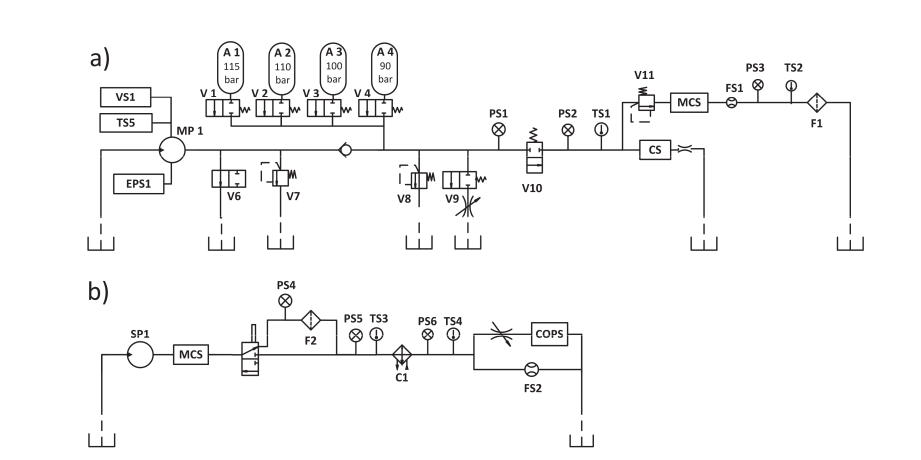

## Leitura dos dados

Não é necessário upar ou salvar os arquivos localmente!

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen


r = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip')  # Link para o arquivo zip
z = ZipFile(BytesIO(r.read()))

sensores_list = ['PS1','PS2','PS3','PS4','PS5','PS6',
                 'EPS1','FS1','FS2',
                 'TS1','TS2','TS3','TS4',
                 'VS1','CE','CP','SE','profile']  # Nome dos arquivos (e keys do dicionário)
X = {}  # Salvando em um dicionário
for s in sensores_list:
    X[s] = pd.read_csv(z.open(s+'.txt'), sep='\t', header=None)

## Oversampling

oversampling para conseguir fazer a correlação, colocando tudo na frequencia de 100Hz

In [ ]:
def oversamp(data,hz):
  datanew = data.copy()
  for i in range(len(data.columns)):
    cont = i*hz
    m = (i+1)*hz
    while (cont < m):
      datanew[cont] = data[i]   
      cont = cont + 1
  return datanew 

In [ ]:
# Oversamplig
X_dict = {}
for k, v in {'TS1': 100, 'TS2': 100, 'TS3': 100, 'TS4': 100, 'VS1':100, 'CE': 100,'CP': 100, 'SE': 100, 'FS1': 10, 'FS2': 10}.items():
    X_dict[k] = oversamp(X[k], v)


In [ ]:
X_dict['FS1'].tail(2)



0      1      2      3      4     ...   5995   5996   5997   5998   5999
2203  8.496  8.496  8.496  8.496  8.496  ...  7.793  7.793  7.793  7.793  7.793
2204  8.373  8.373  8.373  8.373  8.373  ...  7.774  7.774  7.774  7.774  7.774

[2 rows x 6000 columns]

In [ ]:
for c in ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1']:
    X_dict[c] = X[c].copy()

In [ ]:
profile = X['profile'][2].copy()


## Boxplot

In [ ]:


def descricao(data):
  desc = pd.DataFrame()
  
  desc['Media'] = data.mean(axis = 1)
  desc['Mediana'] = data.median(axis = 1)
  desc['Q1'] = data.quantile(.25,axis = 1)
  desc['Q3'] = data.quantile(.75,axis = 1)
  desc['Maximo'] = data.max(axis  = 1)
  desc['Minimo'] = data.min(axis = 1)

  return desc
  

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def descplot(profile,desc, titulo, eixoy):
  #mpl.style.use('seaborn')
  fig, ax = plt.subplots(figsize=(30,10))
  
  ax.plot(desc['Mediana'],label = 'Mediana', color = 'tab:blue')
  ax.fill_between(x=range(2205) , y1=desc['Q3'], y2=desc['Q1'], facecolor='tab:blue', alpha=0.3, label = 'Quartil')
  ax.plot(desc['Maximo'],label = 'Máximo', color = 'tab:red')
  ax.plot(desc['Minimo'],label = 'Mínimo', color = 'tab:purple')
  ax.set_title(titulo, fontsize=20)
  ax.set_xlabel('Medições', fontsize=16)
  ax.set_ylabel(eixoy, fontsize=16)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

  #ax2 = ax.twinx()
  #ax2.plot(profile,'k.')
  #ax2.set_ylabel('Resposta', fontsize=16)
  #ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
  #ax2.yaxis.grid()

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=5, prop = {'size': 14})
  plt.show()

In [ ]:
def tplot(X, titulo, eixoy):
  #mpl.style.use('seaborn')
  datanew = X.copy()
  Q1 = np.quantile(datanew.to_numpy().flatten(), .25)
  Q3 = np.quantile(datanew.to_numpy().flatten(), .75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR
  
  fig, ax = plt.subplots(figsize=(30,10))
  
  ax.plot(X, color='0.8', alpha = 0.05)
  ax.set_title(titulo, fontsize=20)
  ax.set_xlabel('Medições', fontsize=16)
  ax.set_ylabel(eixoy, fontsize=16)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

  ax.hlines(upper,0,2204,label = 'Limite Superior',lw = 3,color = 'tab:red')
  ax.hlines(lower,0,2204,label = 'Limite Inferior',lw = 3,color= 'tab:purple')

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
            fancybox=True, shadow=True, ncol=5, prop = {'size': 14})
  plt.show()

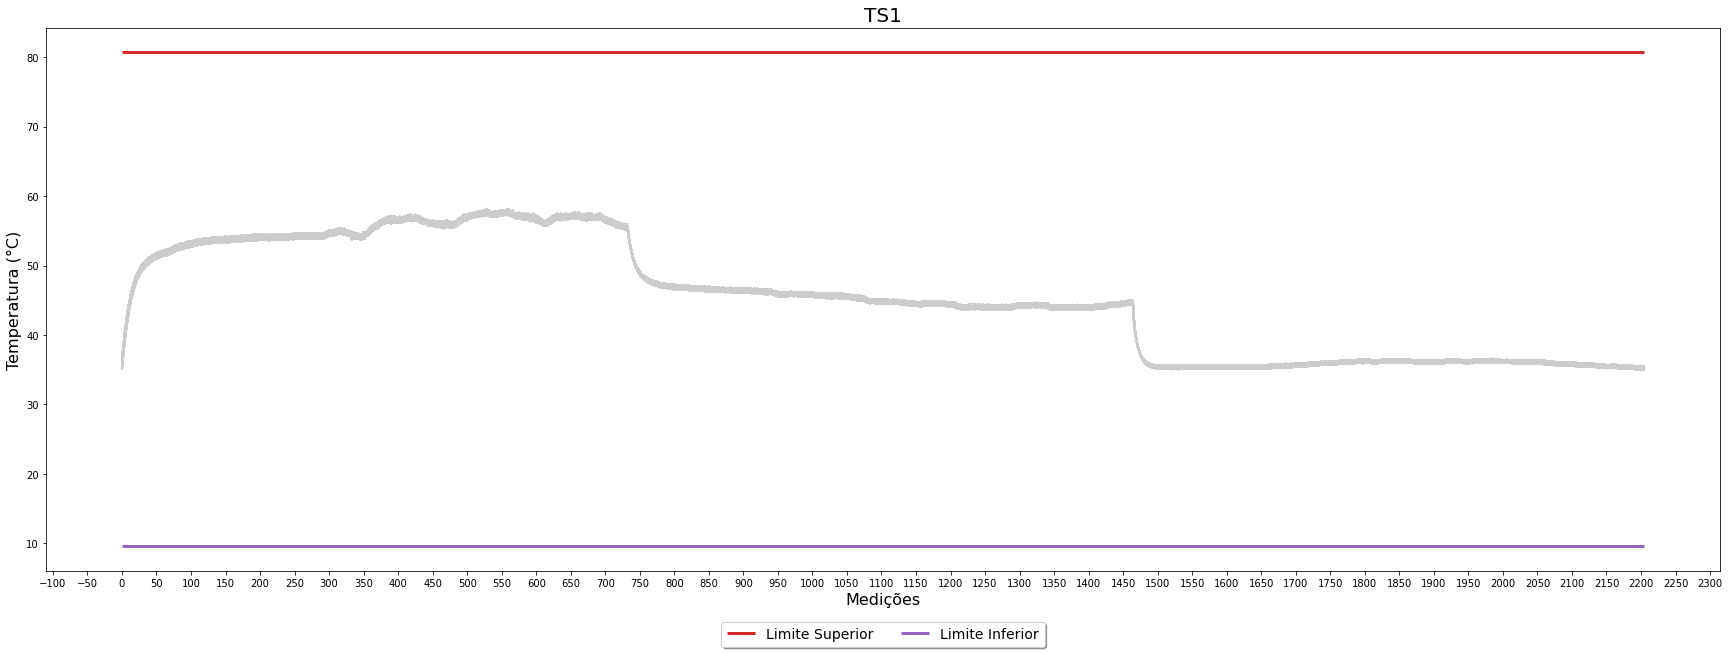

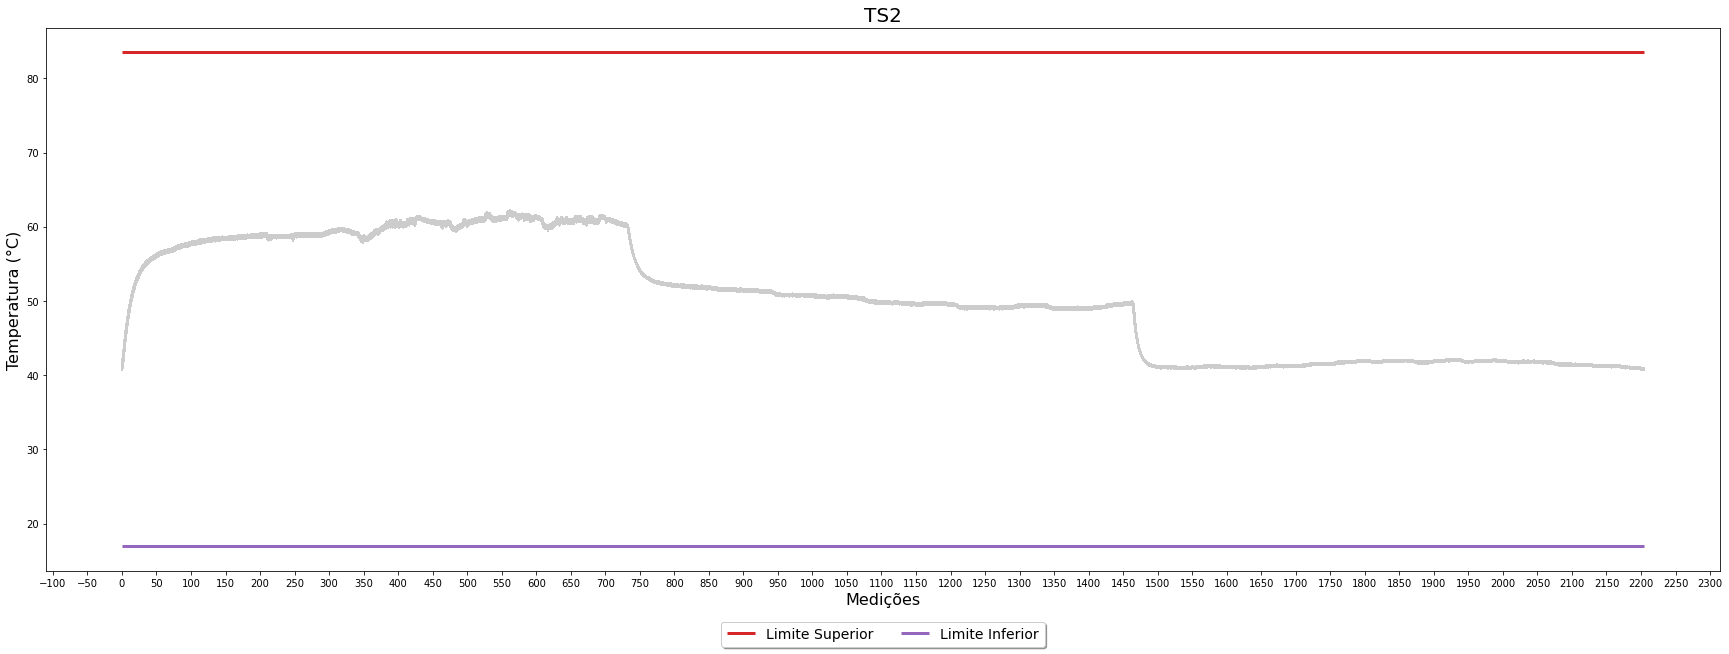

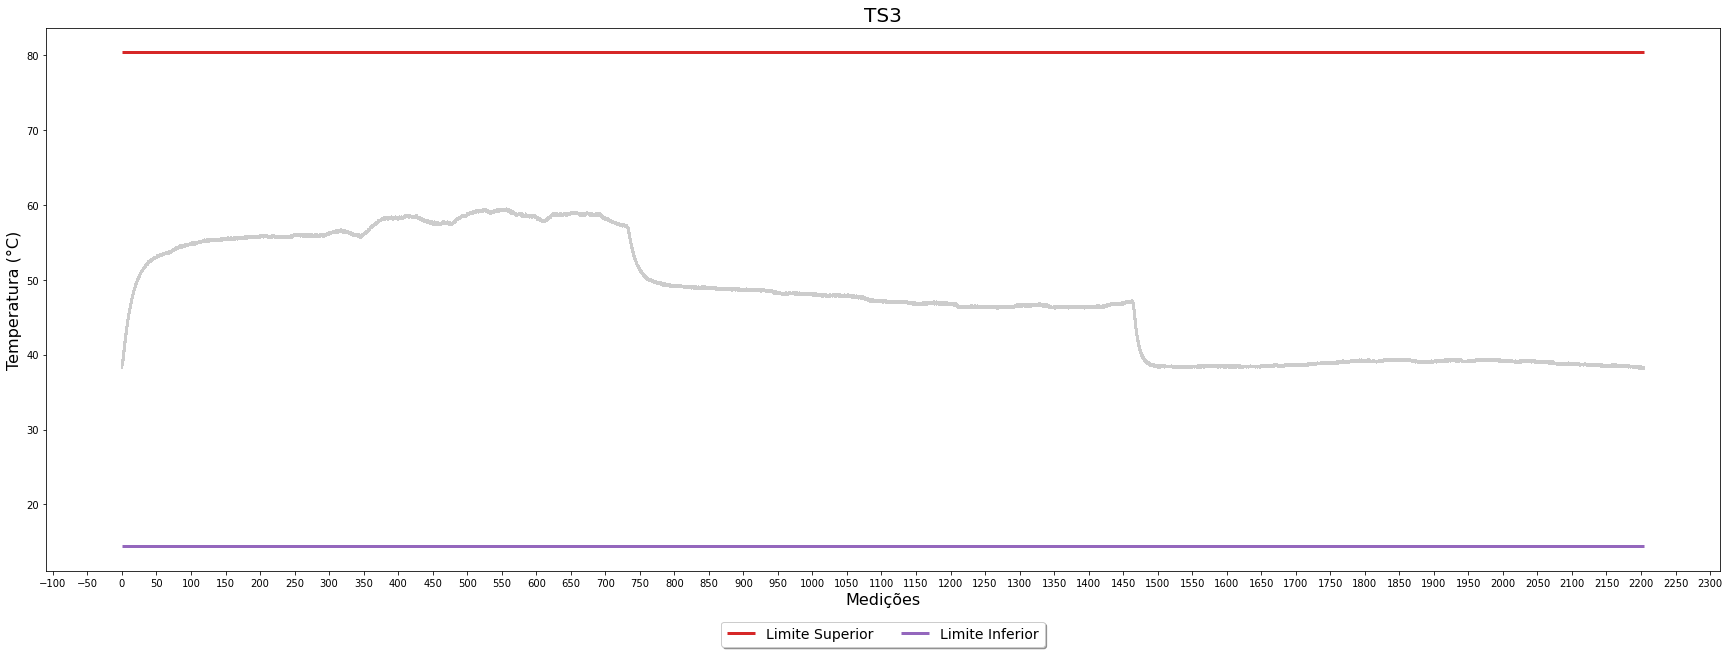

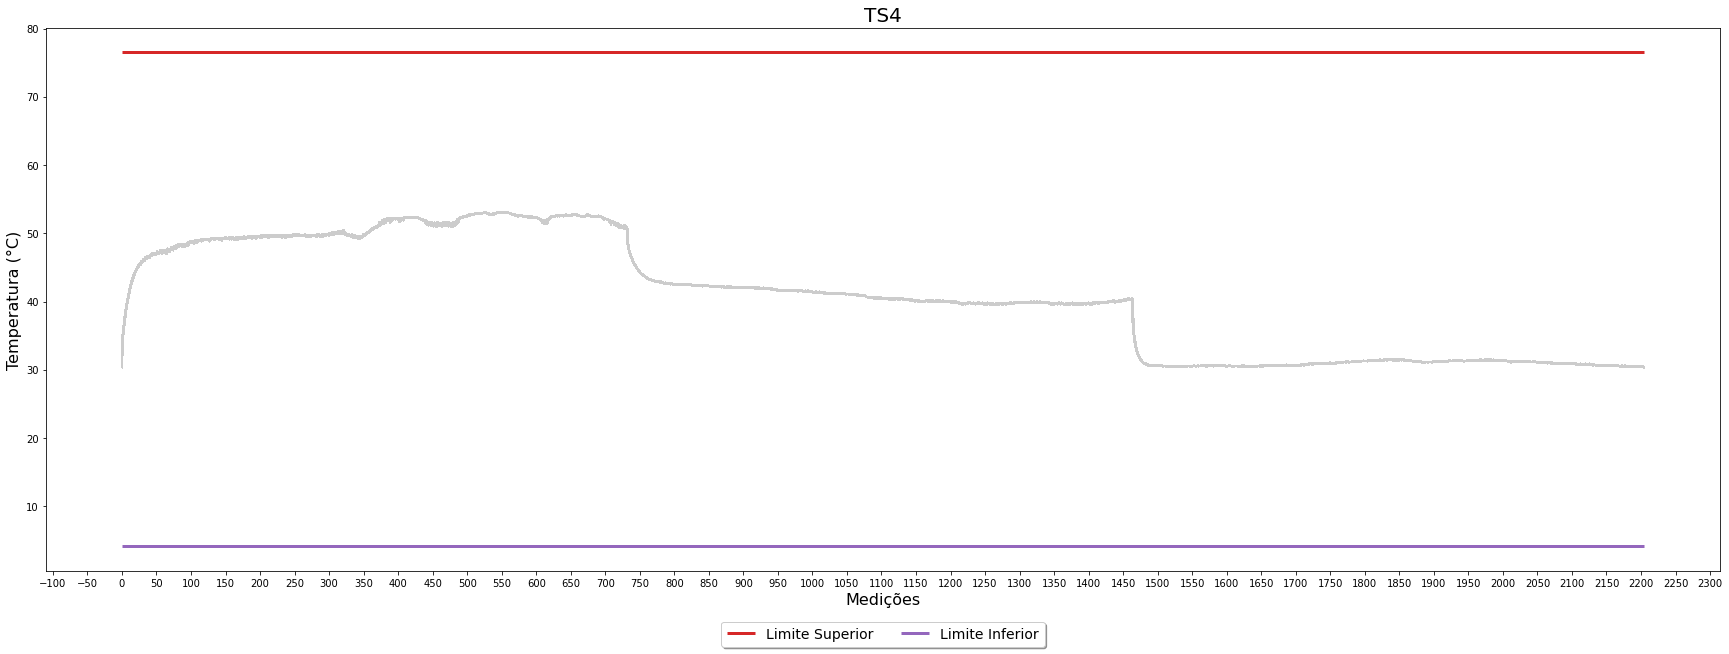

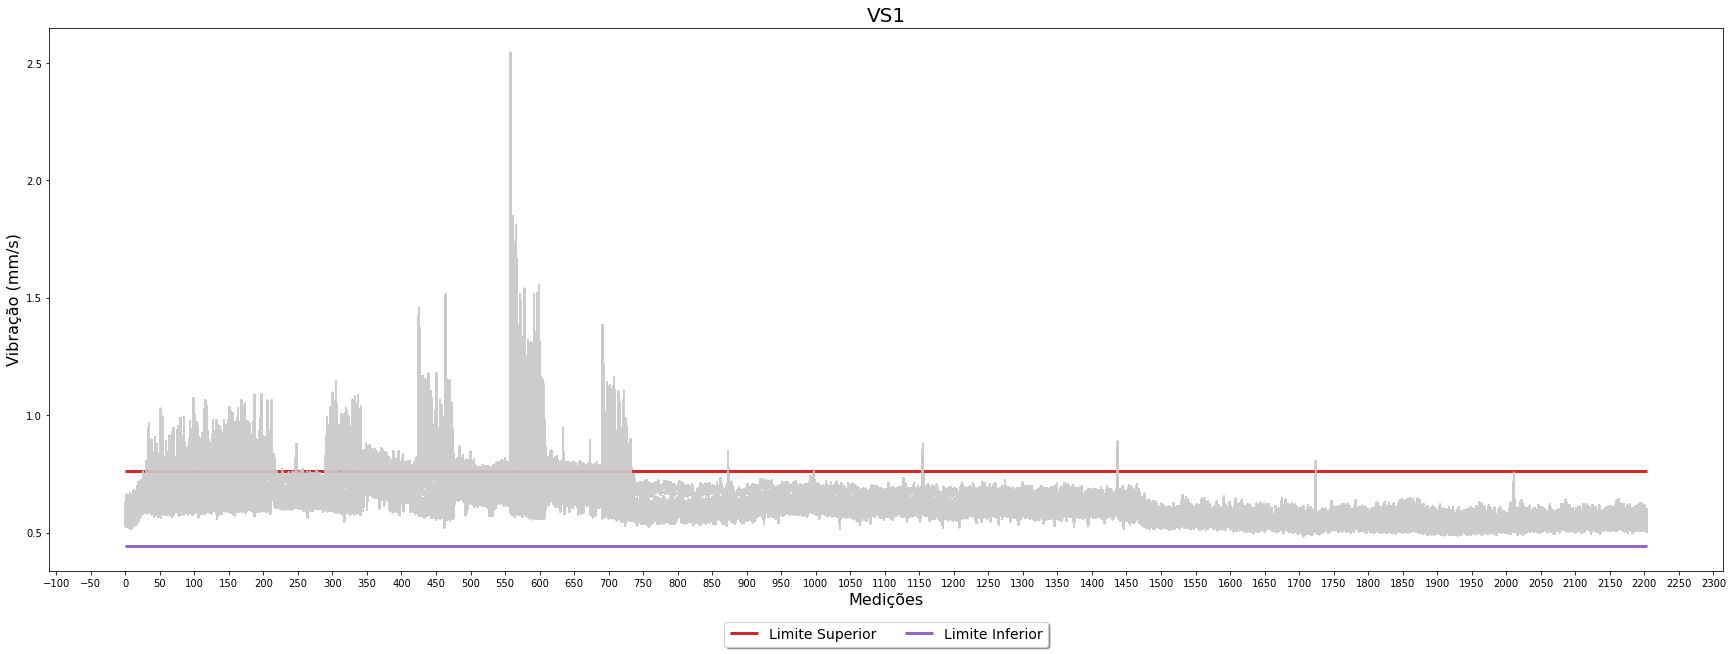

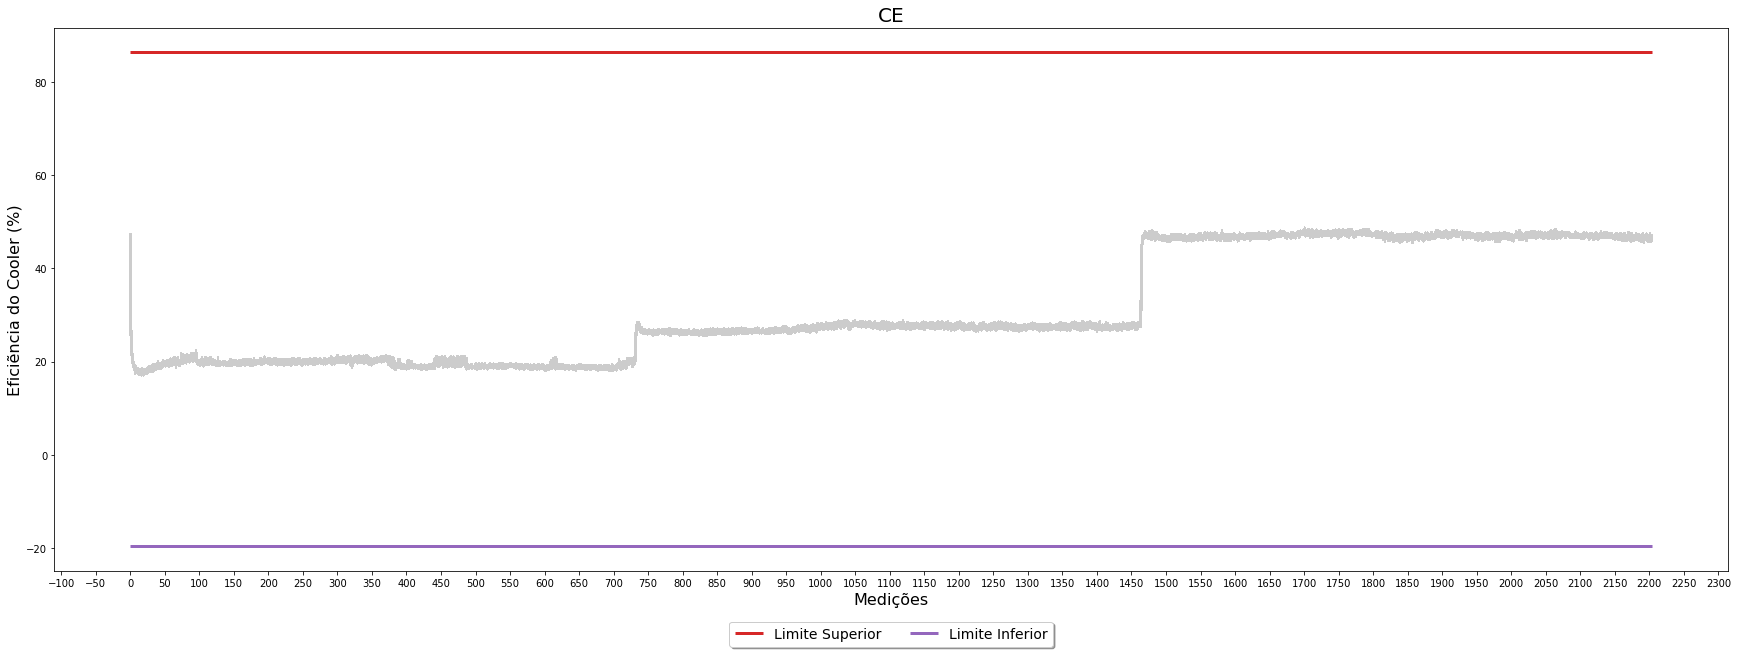

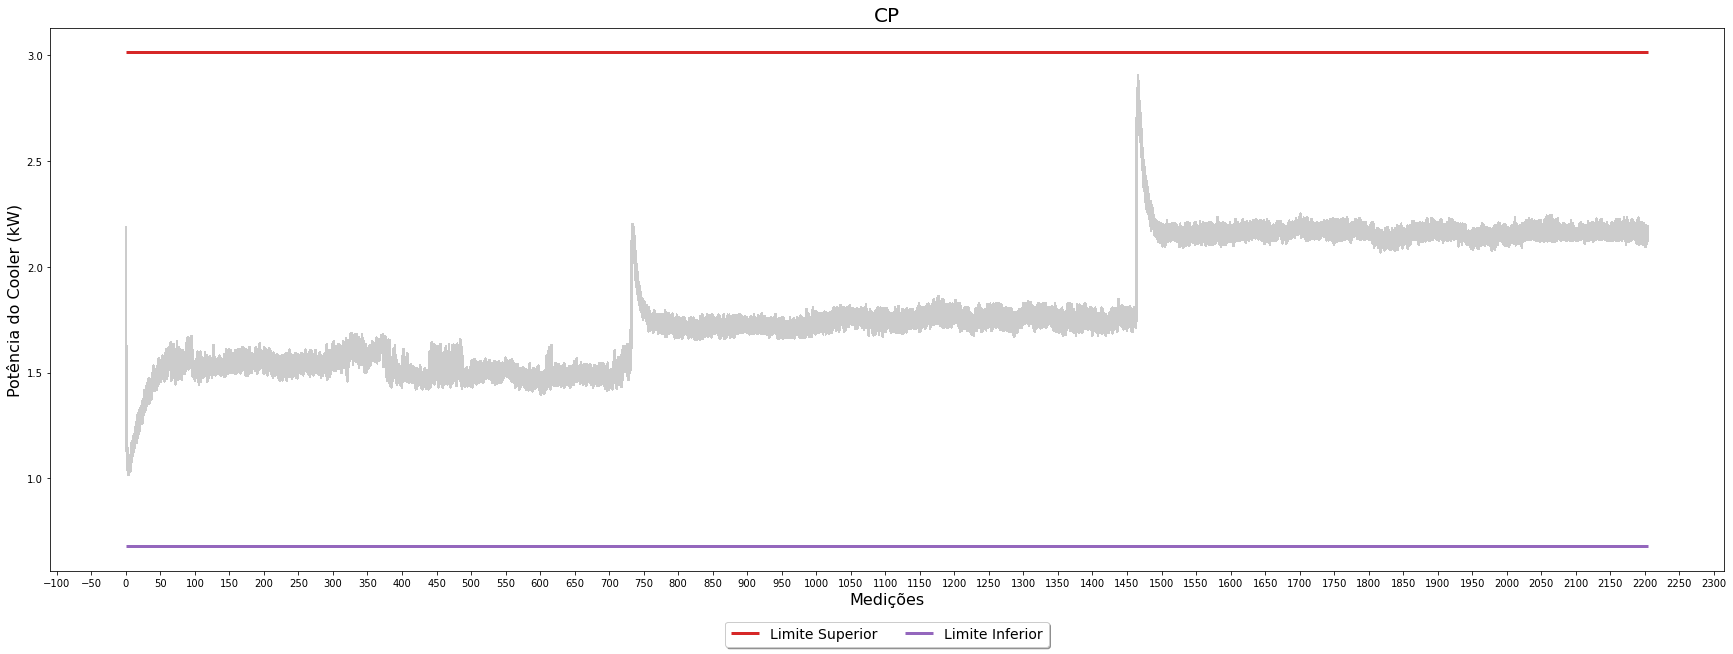

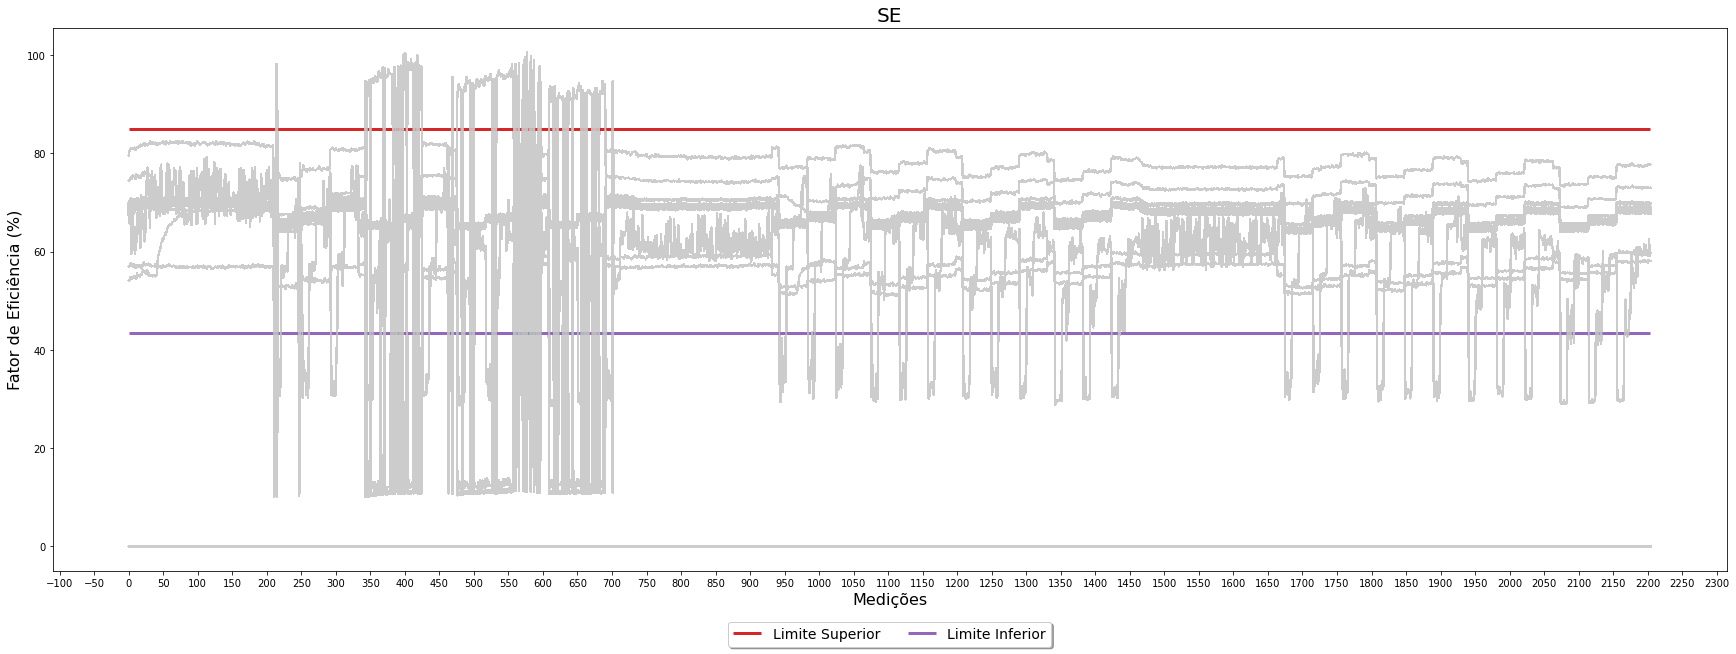

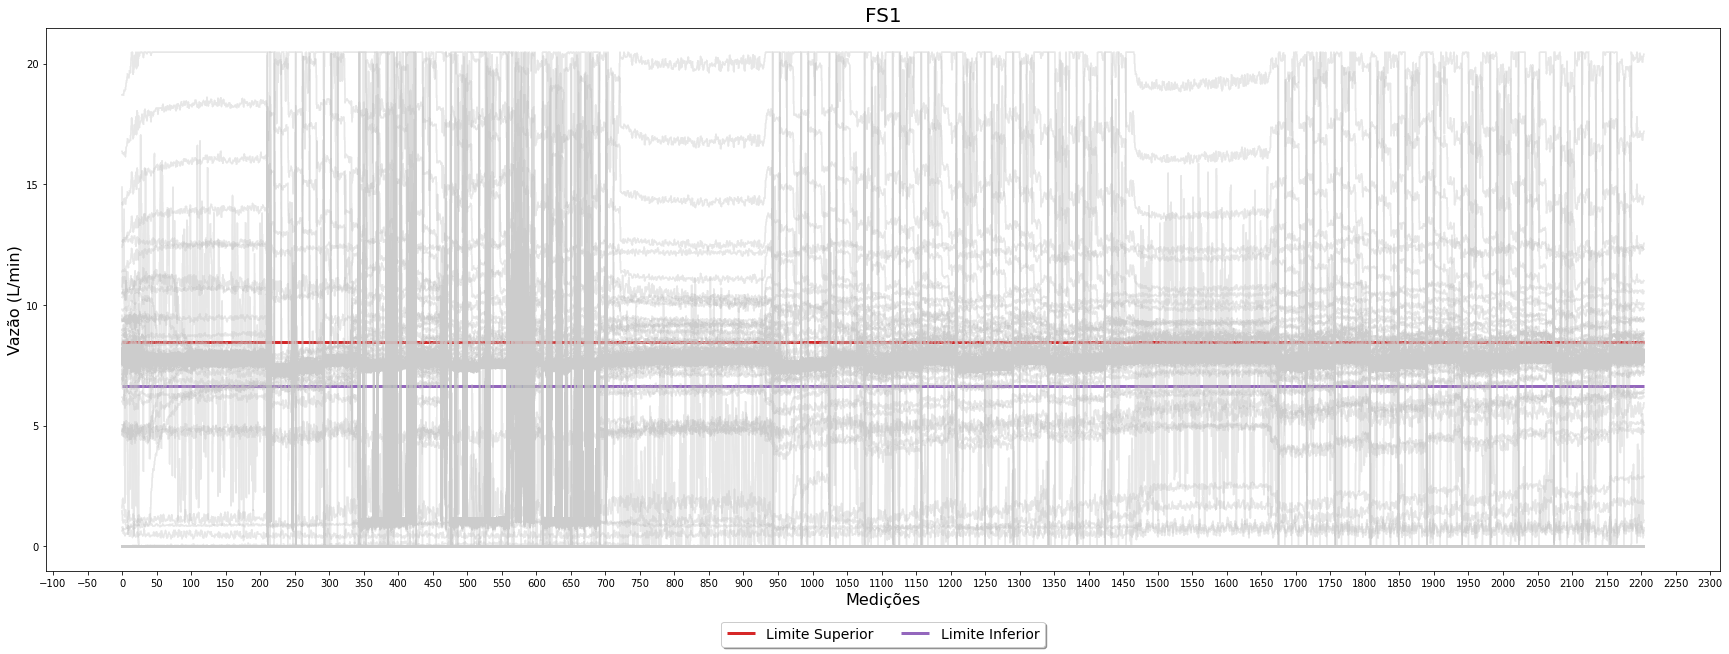

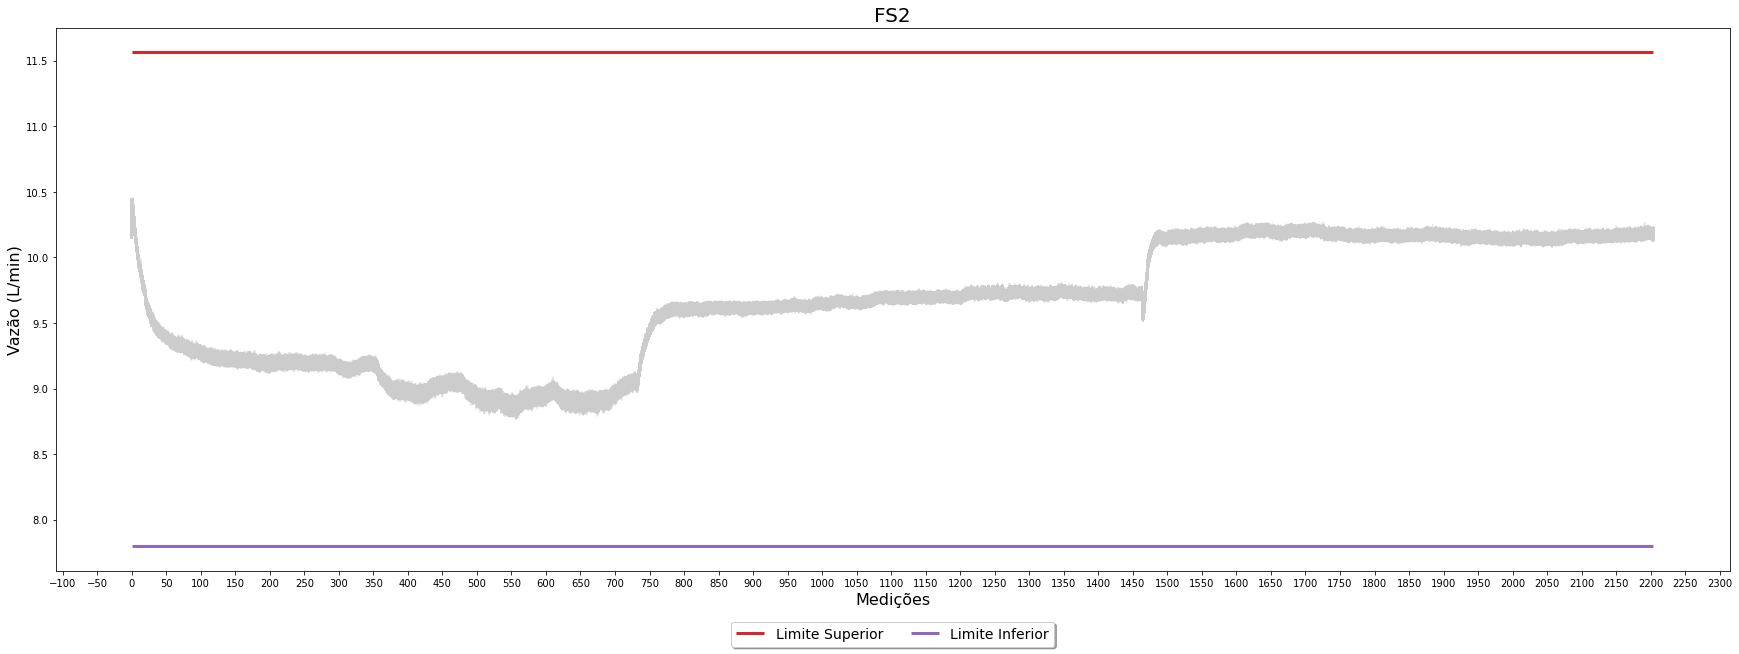

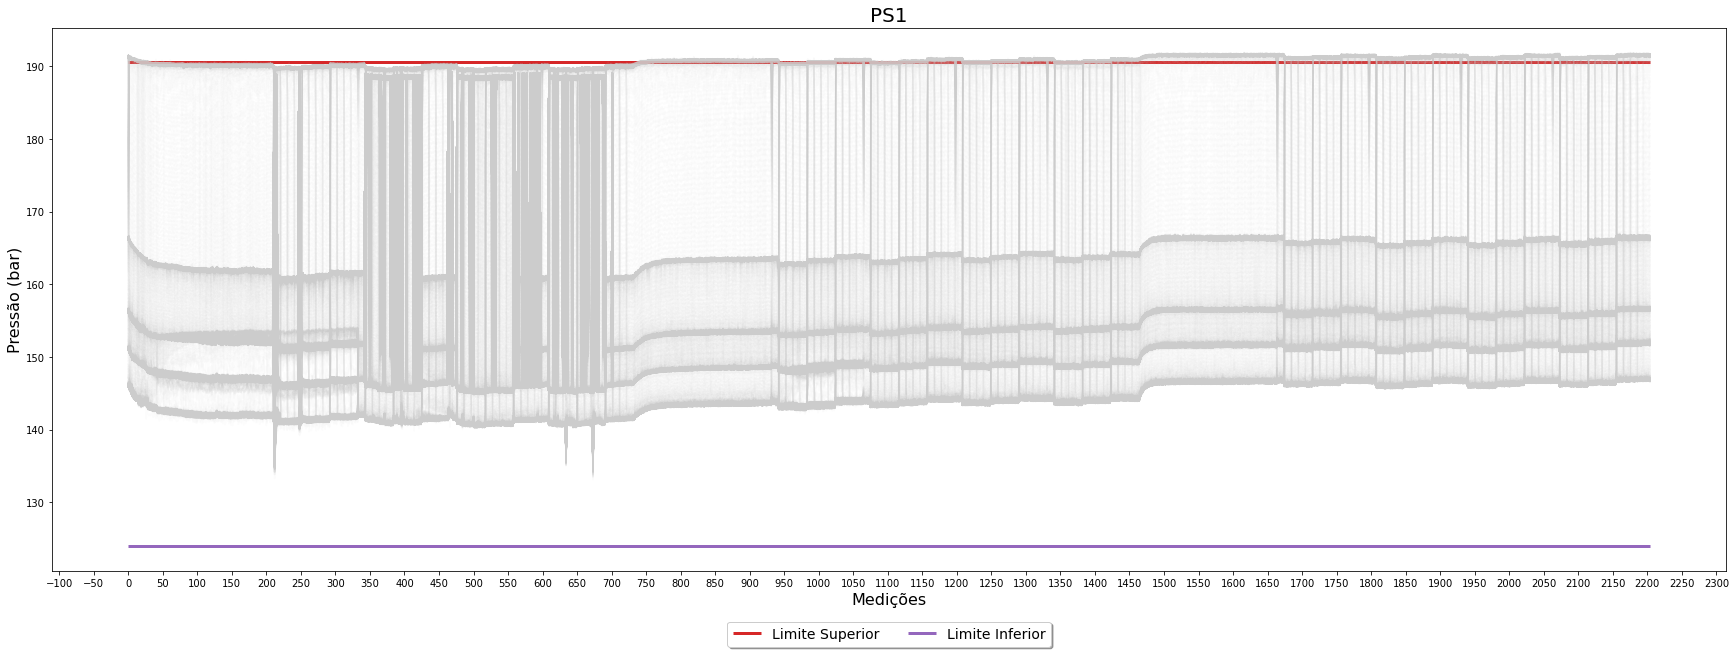

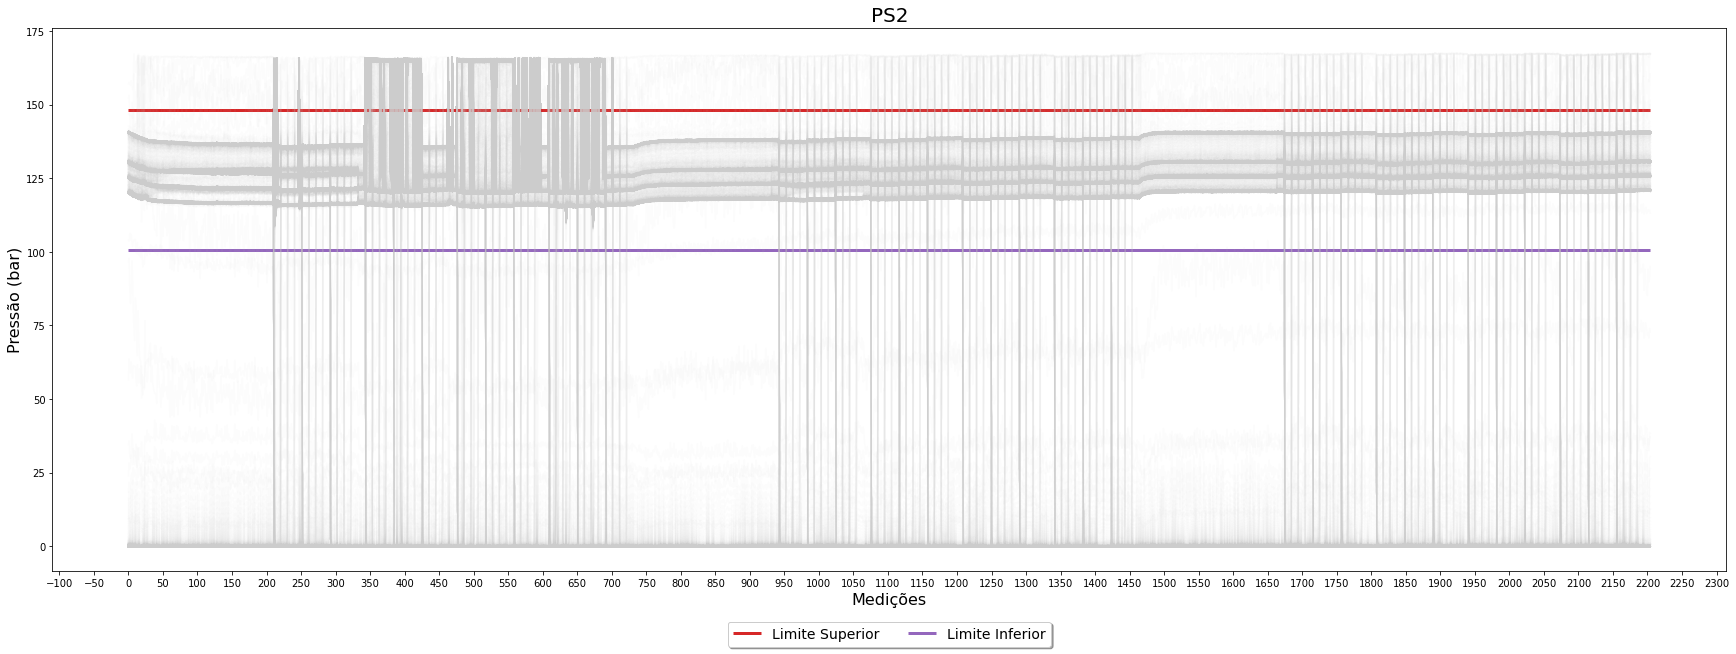

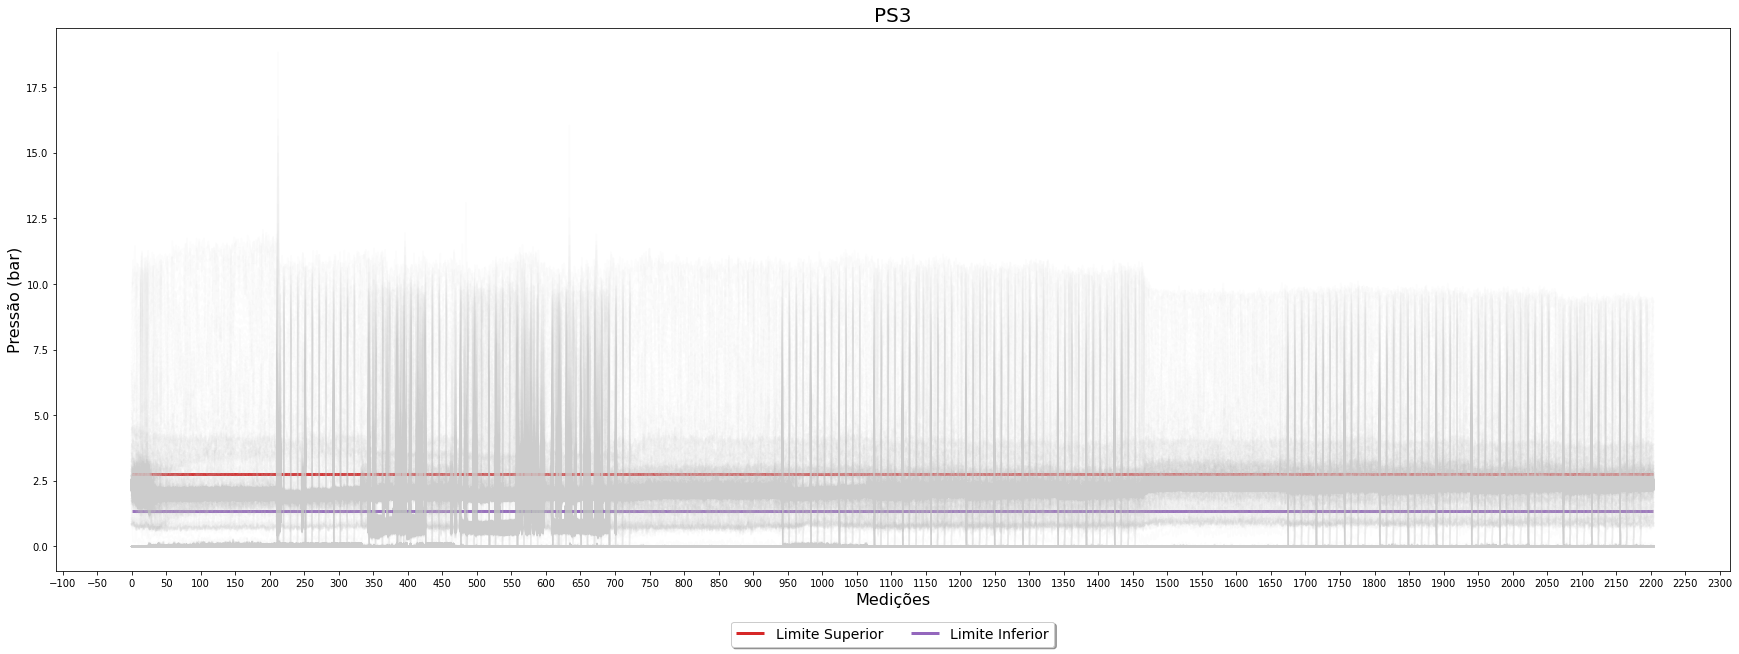

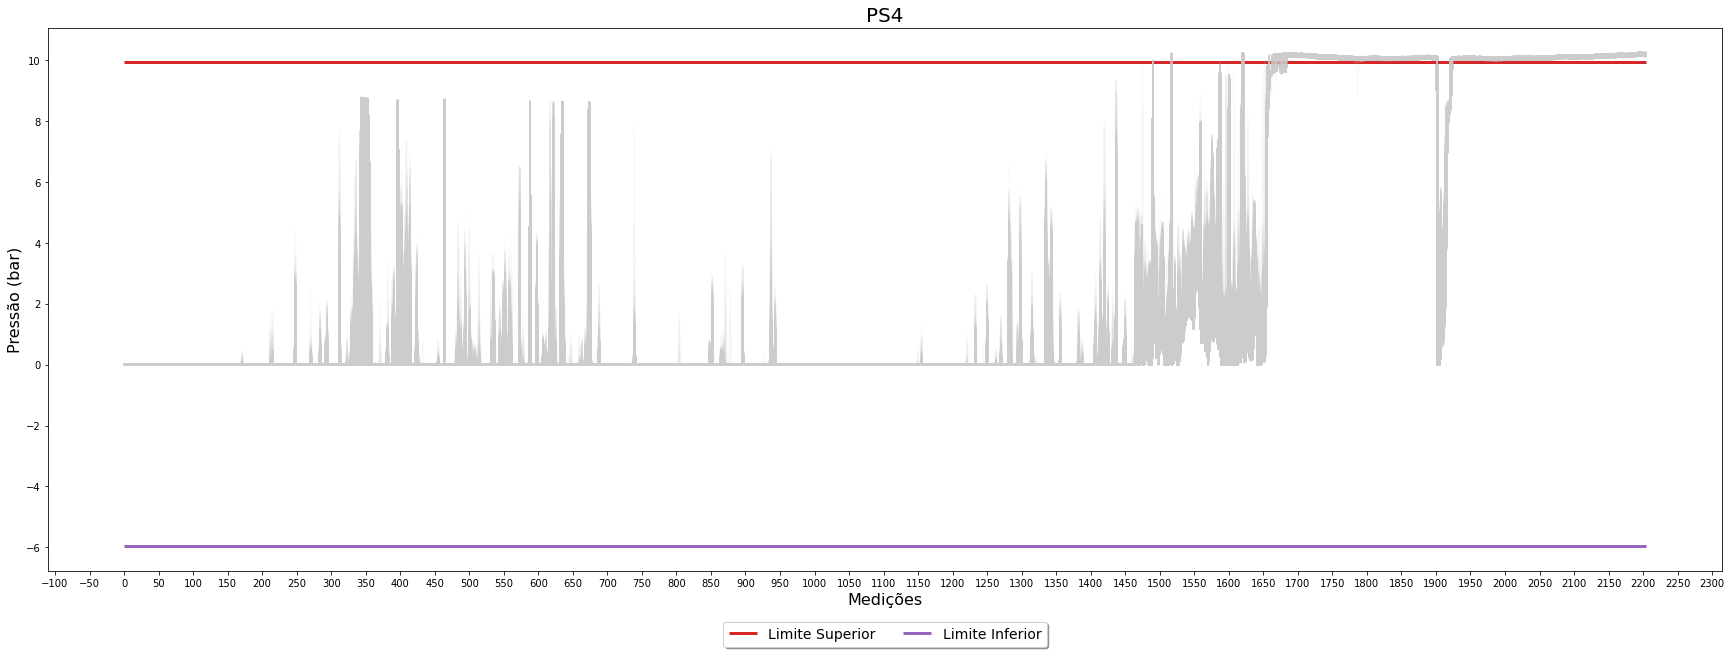

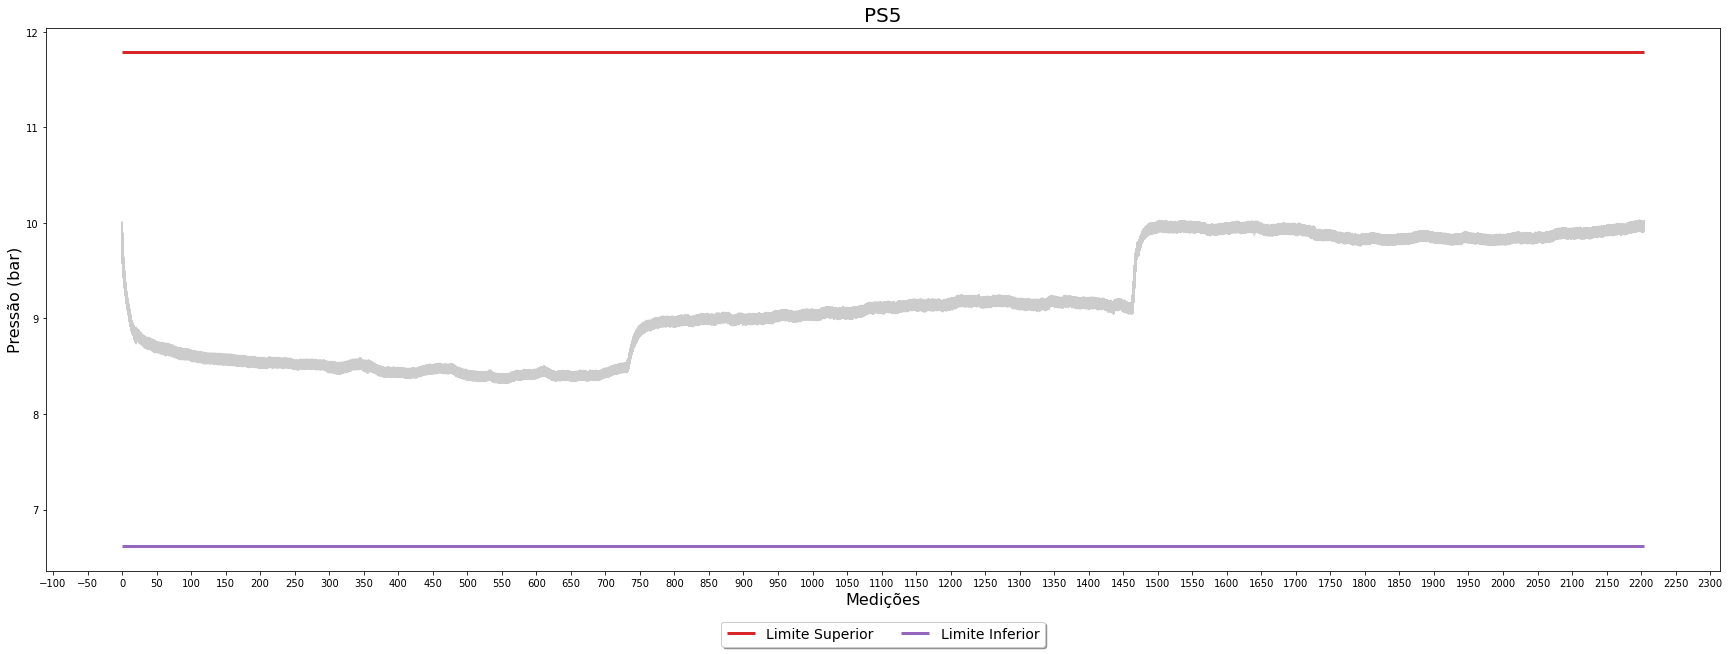

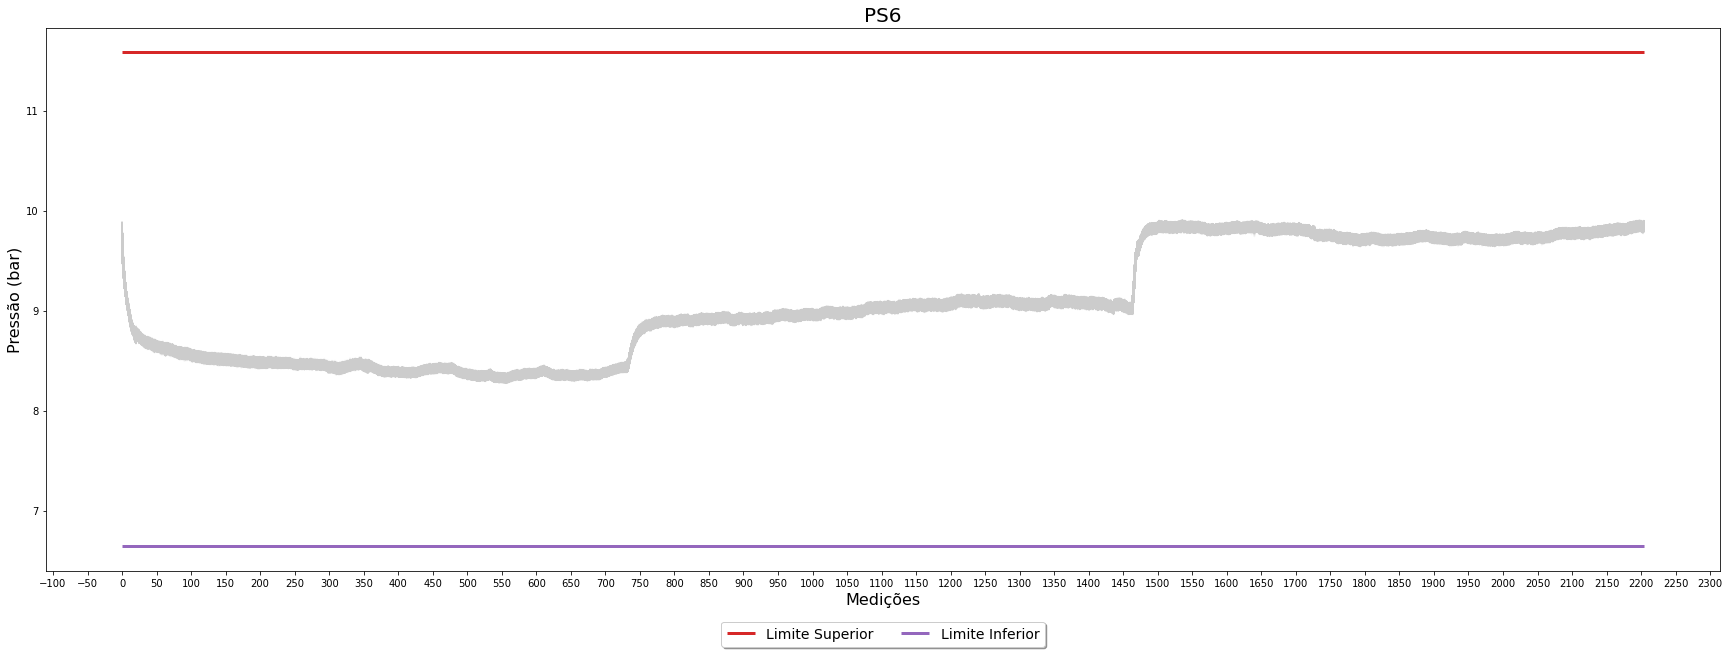

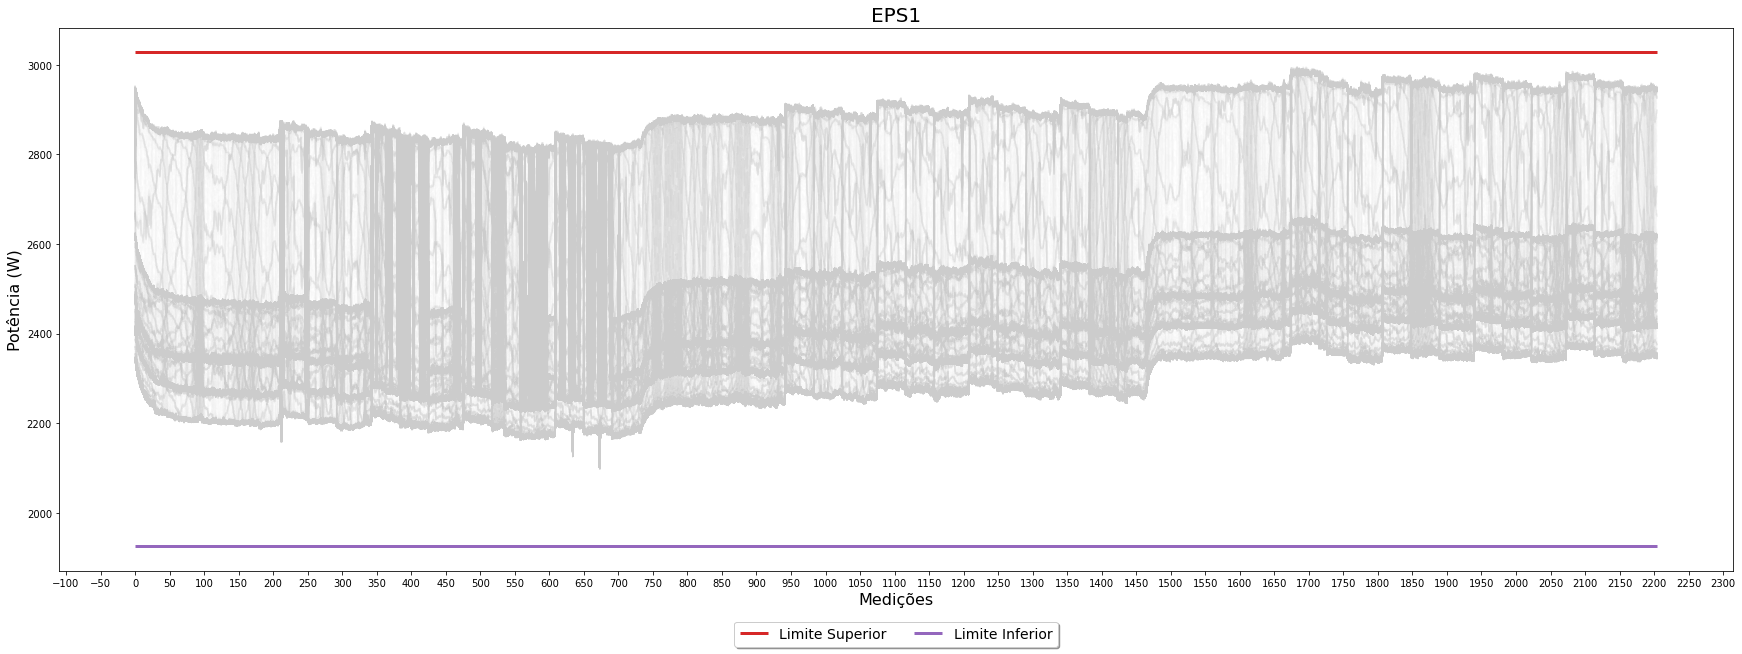

In [ ]:
for c, u in zip(X_dict.keys(), ['Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)',
                                'Vibração (mm/s)', 'Eficiẽncia do Cooler (%)', 'Potência do Cooler (kW)', 'Fator de Eficiência (%)',
                                'Vazão (L/min)', 'Vazão (L/min)',
                                'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)',
                                'Potência (W)']):
    tplot(X_dict[c], c, u)

In [ ]:
X_dict['FS1']

0      1      2      3      4     ...   5995   5996   5997   5998   5999
0     8.990  8.990  8.990  8.990  8.990  ...  8.036  8.036  8.036  8.036  8.036
1     8.919  8.919  8.919  8.919  8.919  ...  7.890  7.890  7.890  7.890  7.890
2     9.179  9.179  9.179  9.179  9.179  ...  7.952  7.952  7.952  7.952  7.952
3     9.034  9.034  9.034  9.034  9.034  ...  7.773  7.773  7.773  7.773  7.773
4     8.729  8.729  8.729  8.729  8.729  ...  7.825  7.825  7.825  7.825  7.825
...     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
2200  8.173  8.173  8.173  8.173  8.173  ...  7.874  7.874  7.874  7.874  7.874
2201  8.317  8.317  8.317  8.317  8.317  ...  7.787  7.787  7.787  7.787  7.787
2202  8.170  8.170  8.170  8.170  8.170  ...  7.685  7.685  7.685  7.685  7.685
2203  8.496  8.496  8.496  8.496  8.496  ...  7.793  7.793  7.793  7.793  7.793
2204  8.373  8.373  8.373  8.373  8.373  ...  7.774  7.774  7.774  7.774  7.774

[2205 rows x 6000 columns]

In [ ]:
X_dict.keys()

dict_keys(['TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1'])

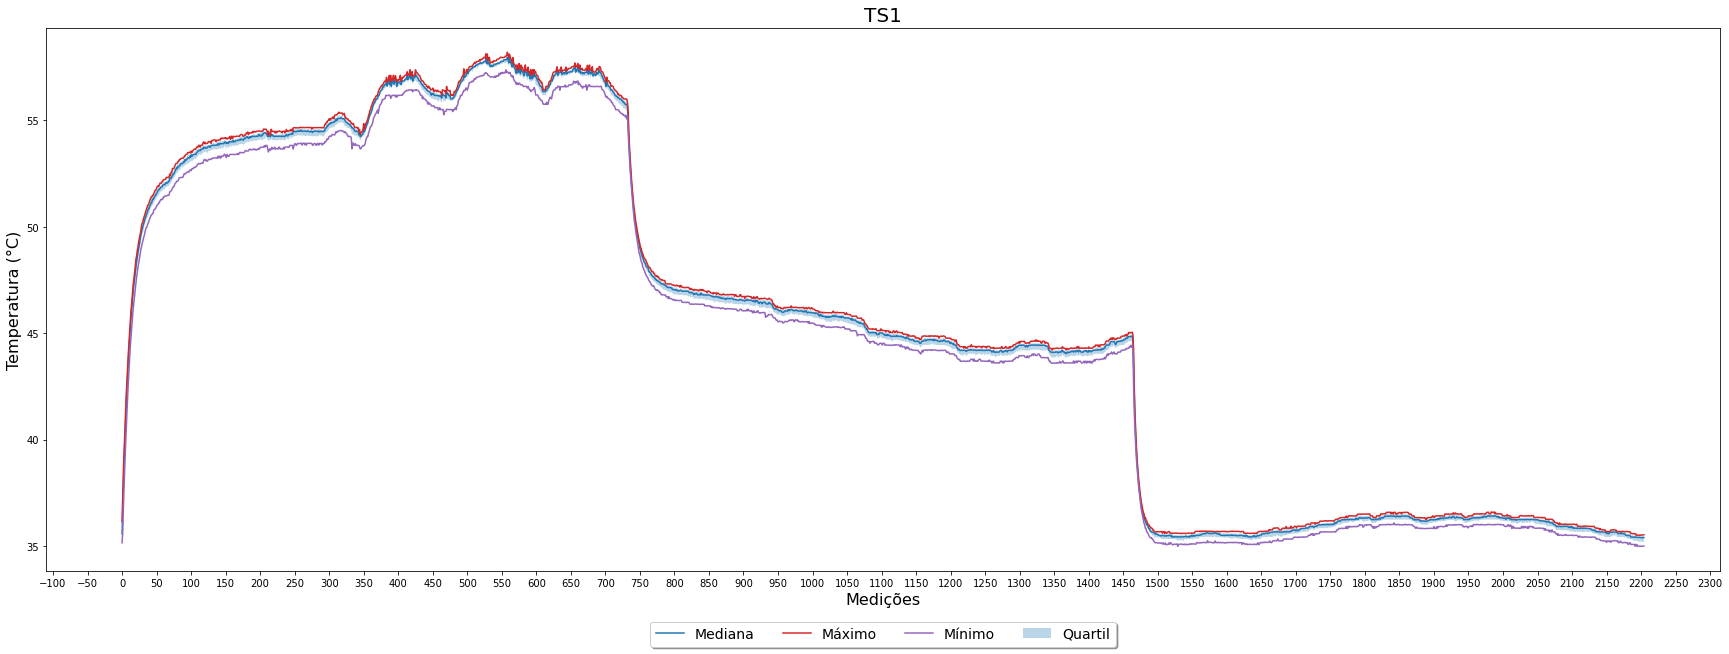

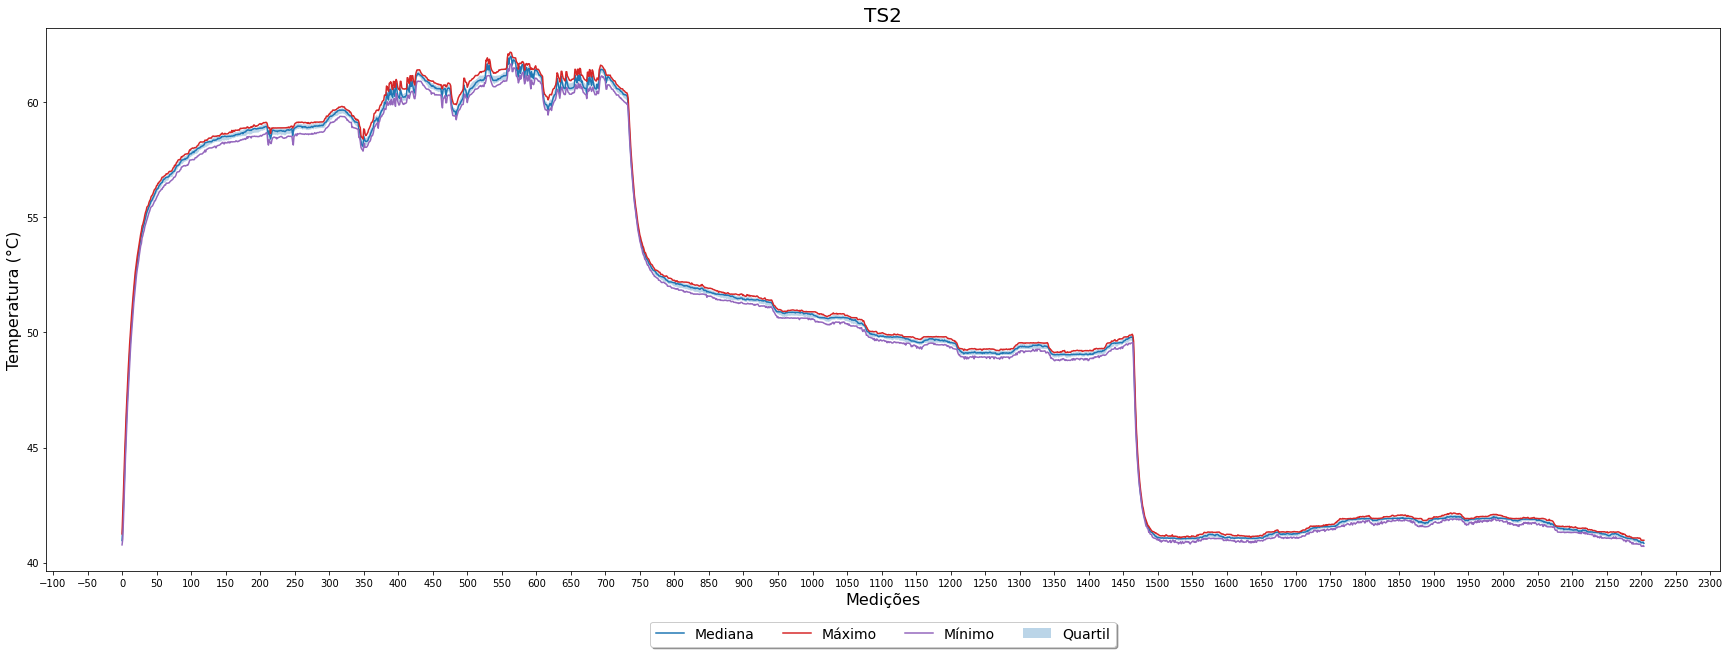

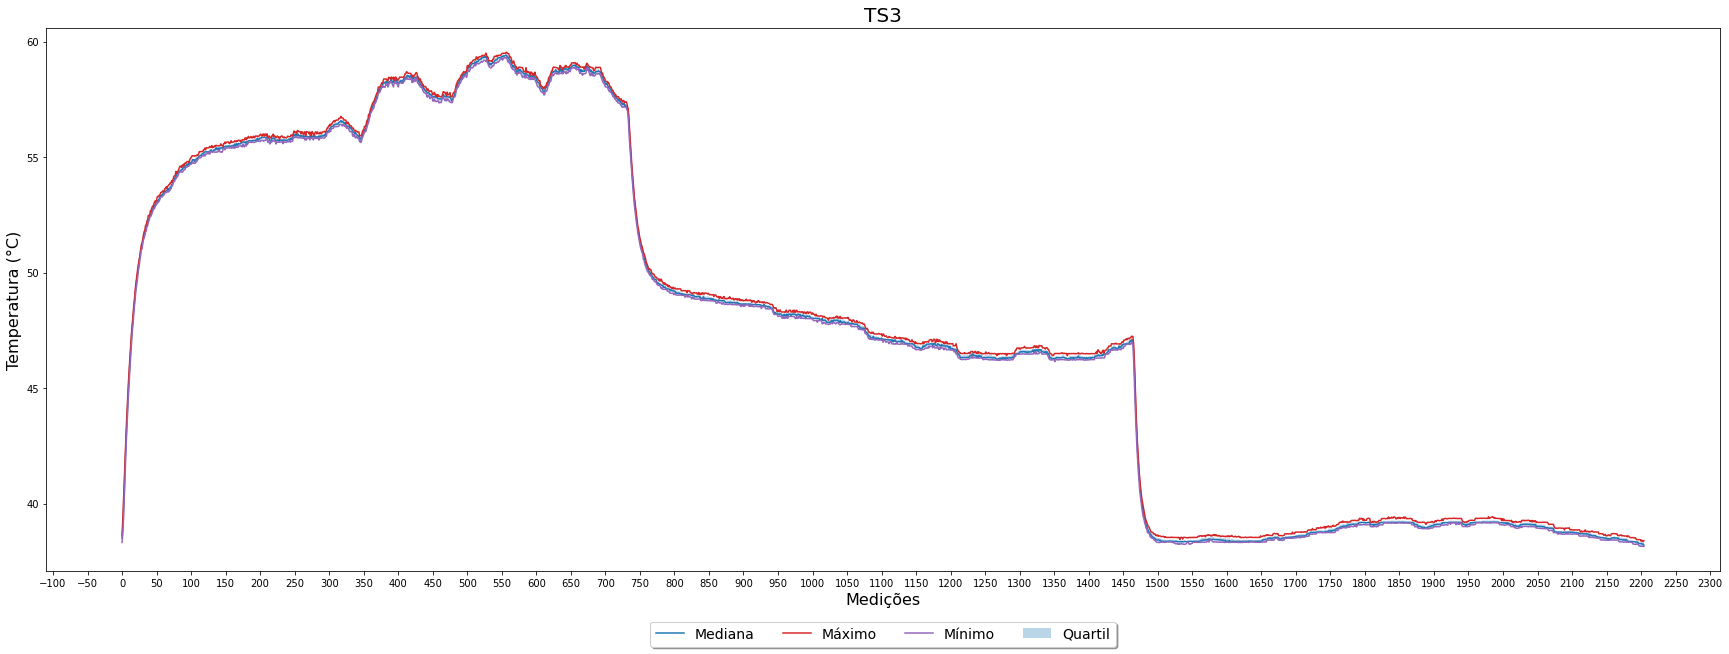

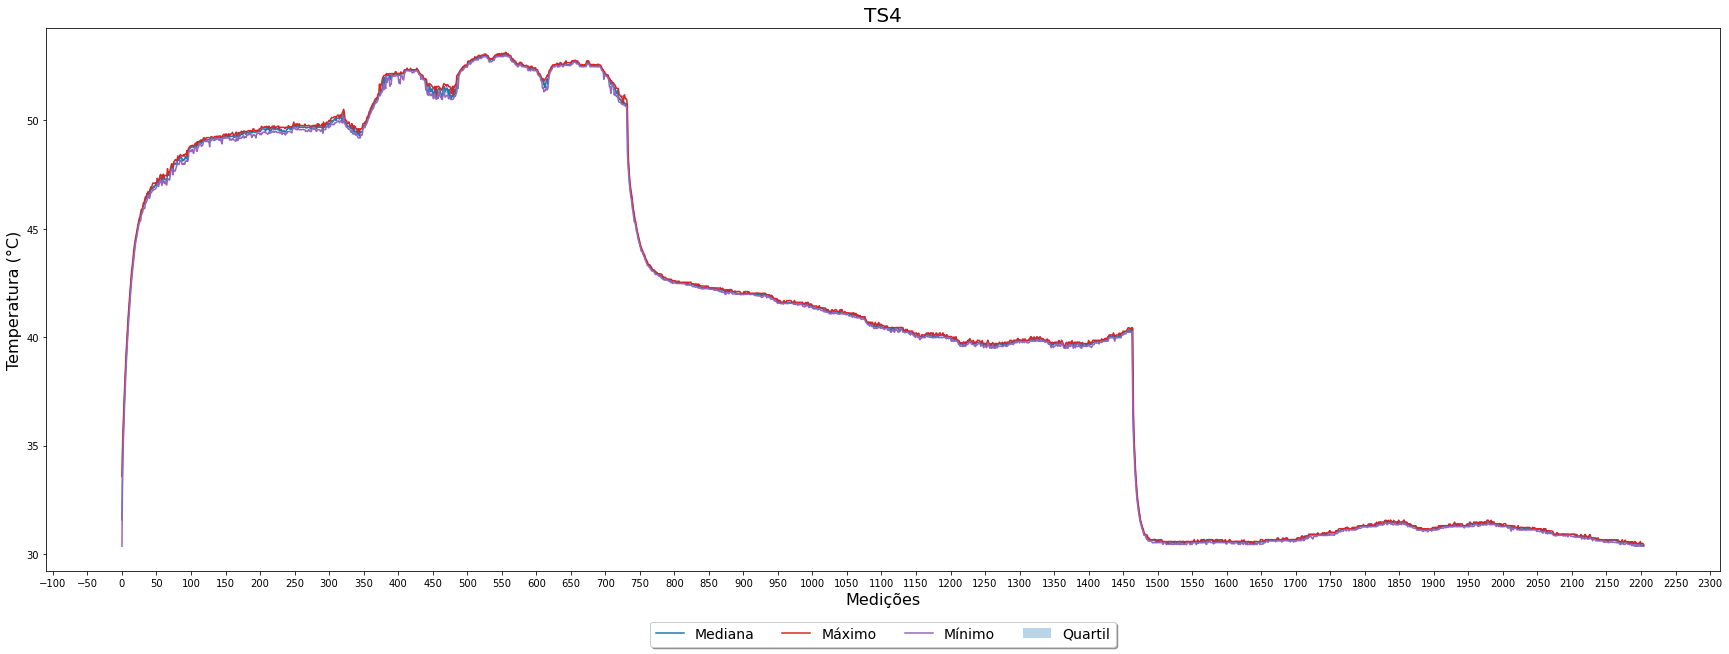

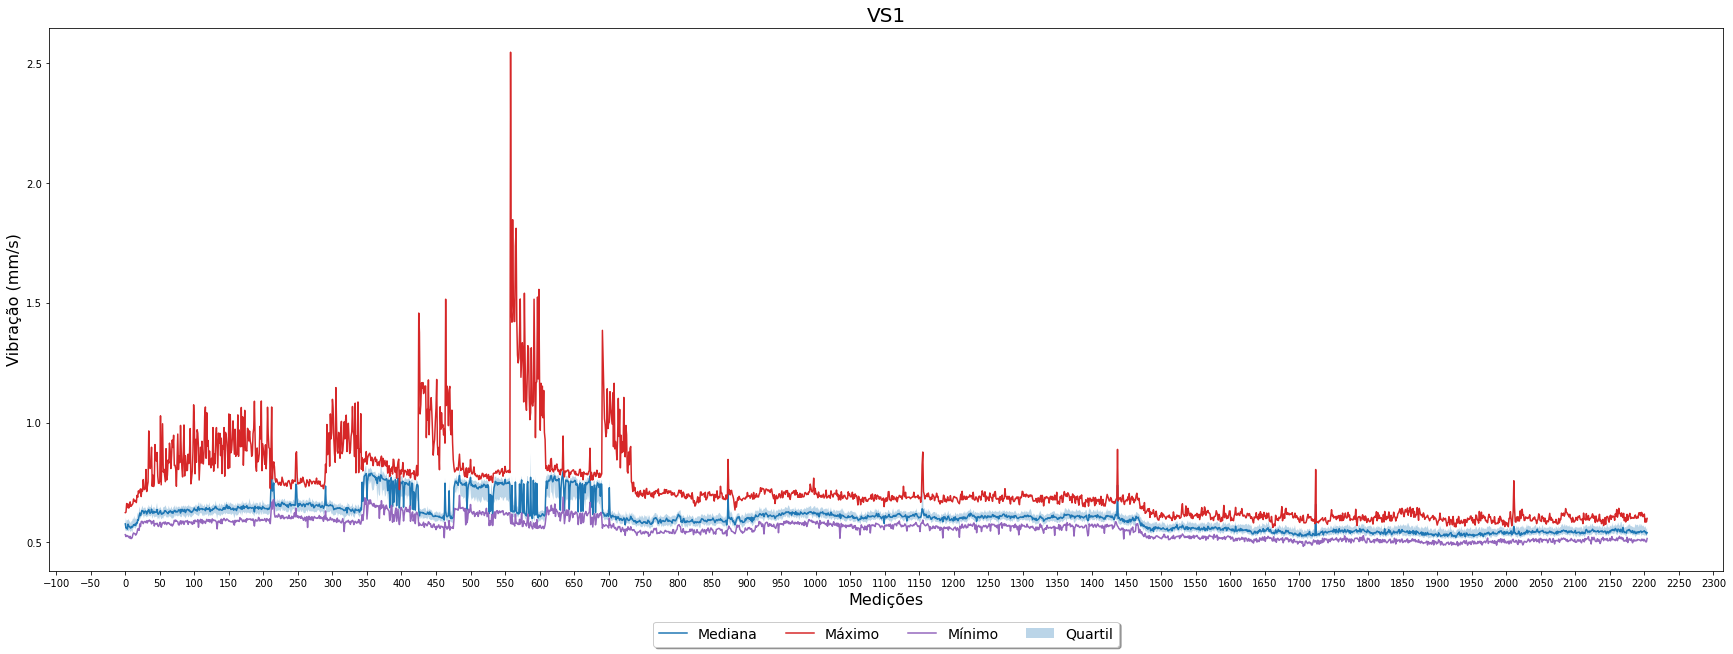

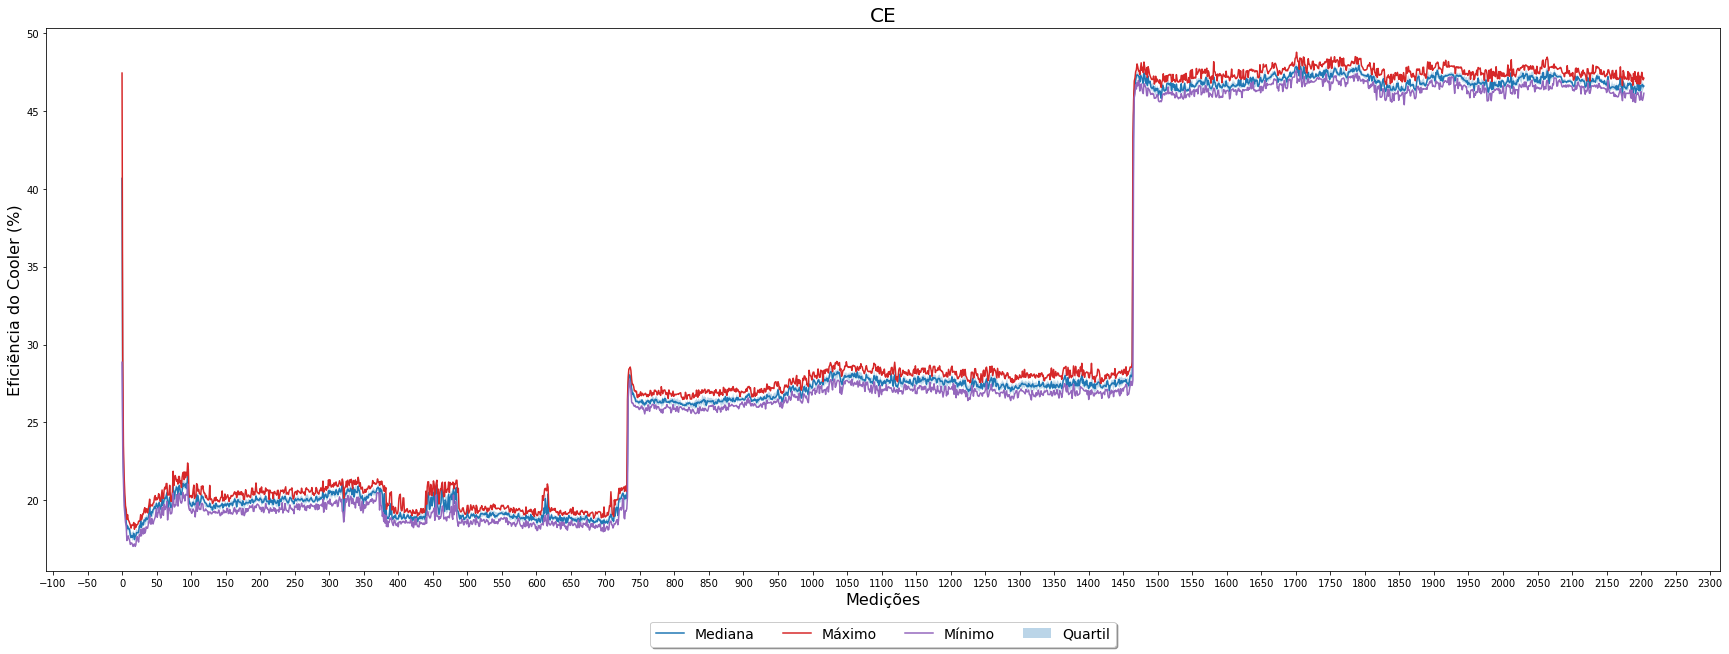

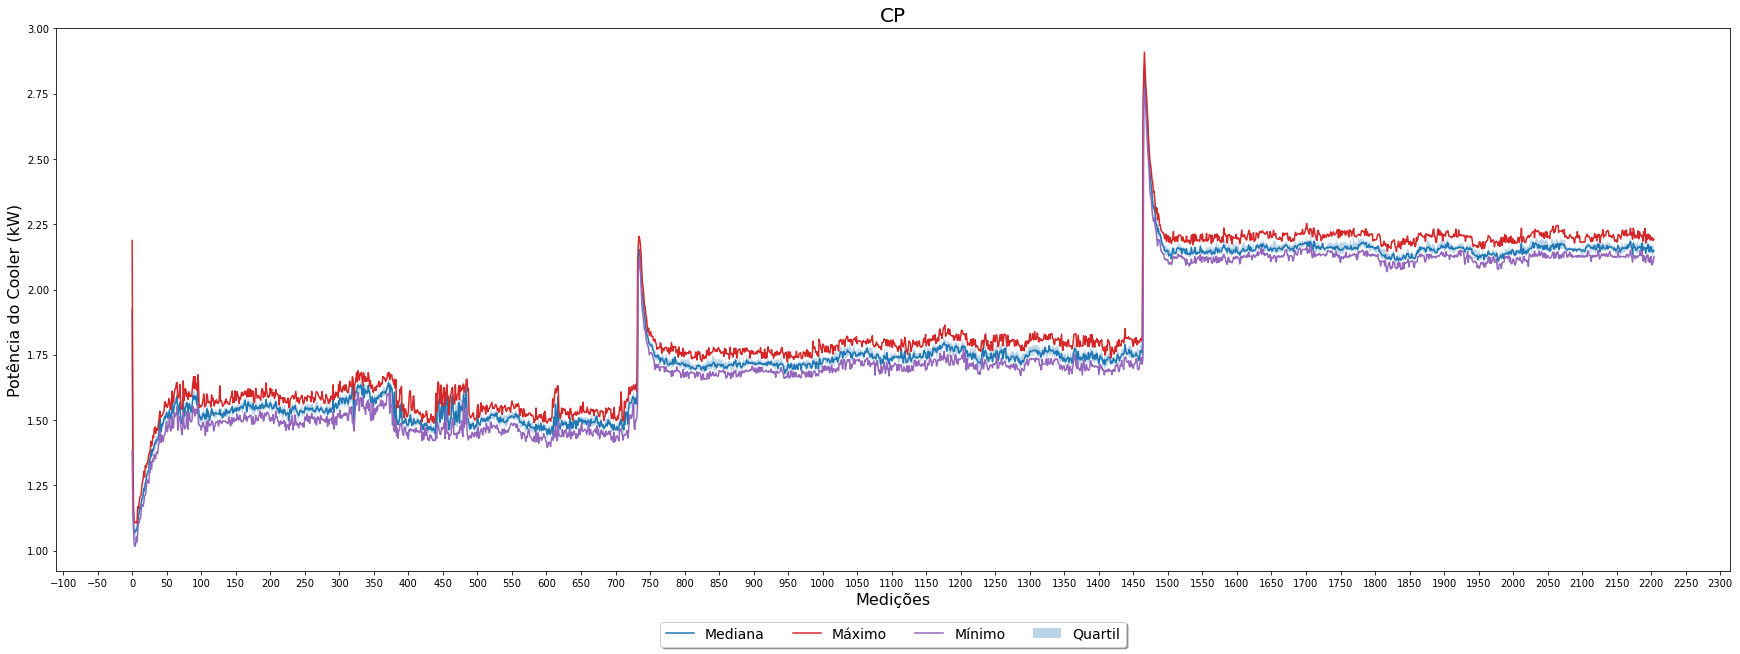

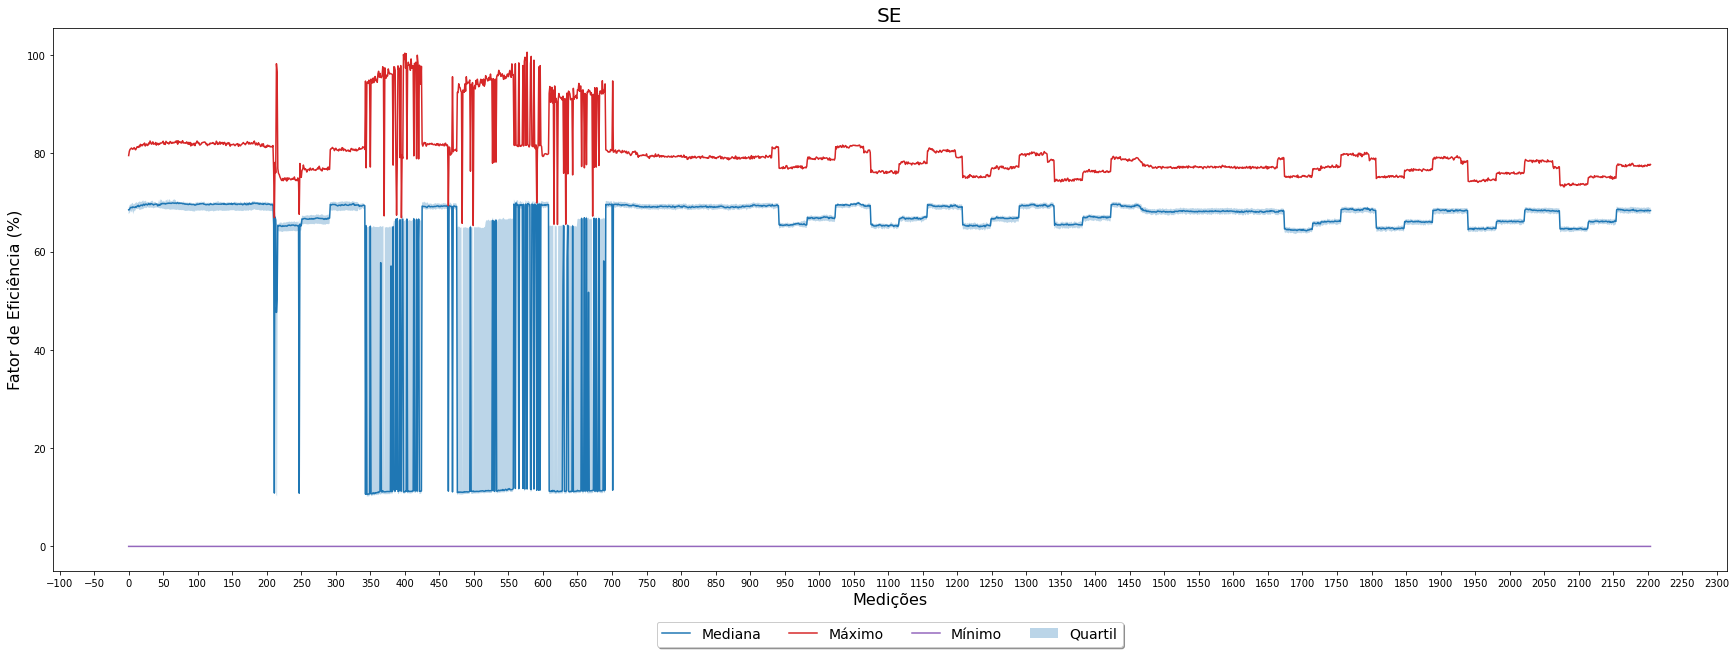

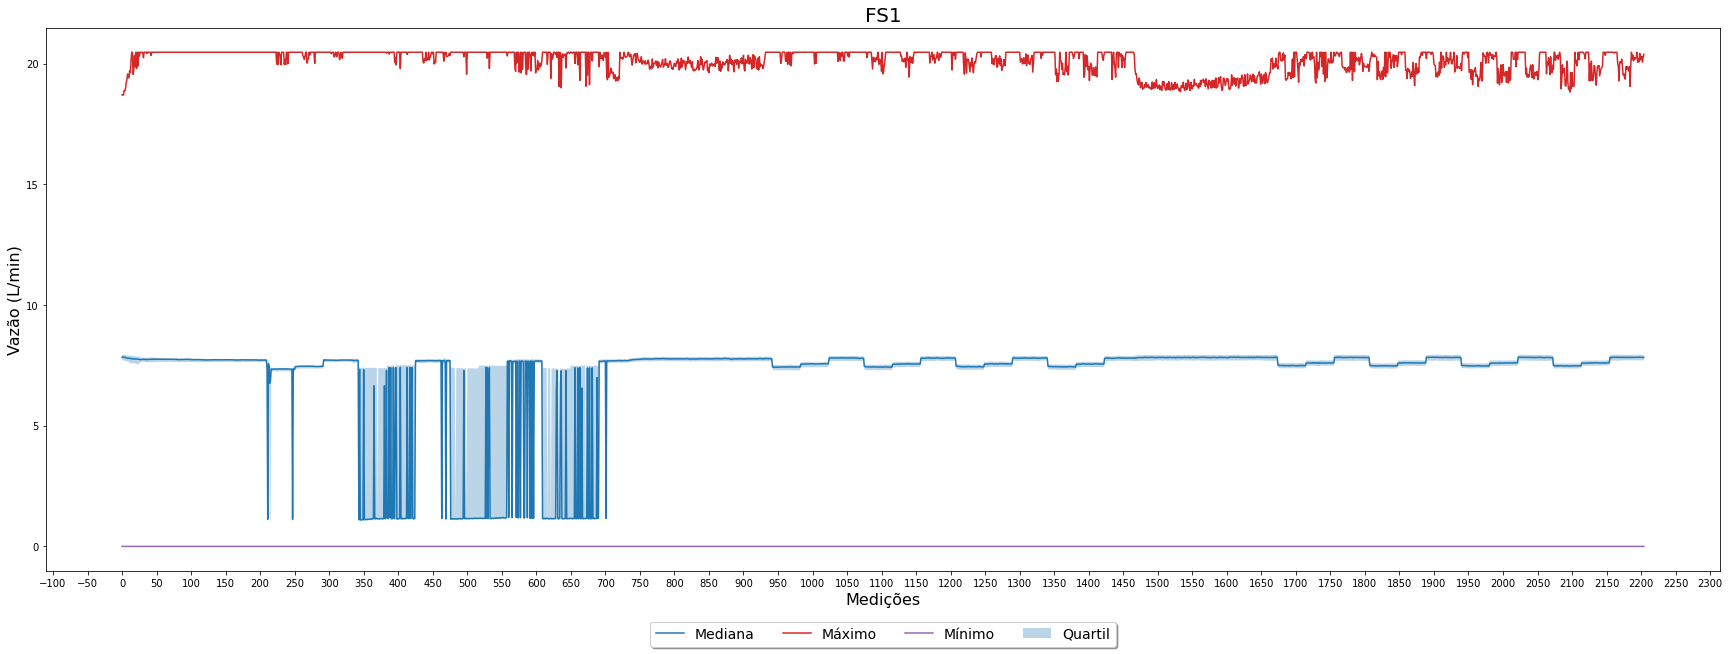

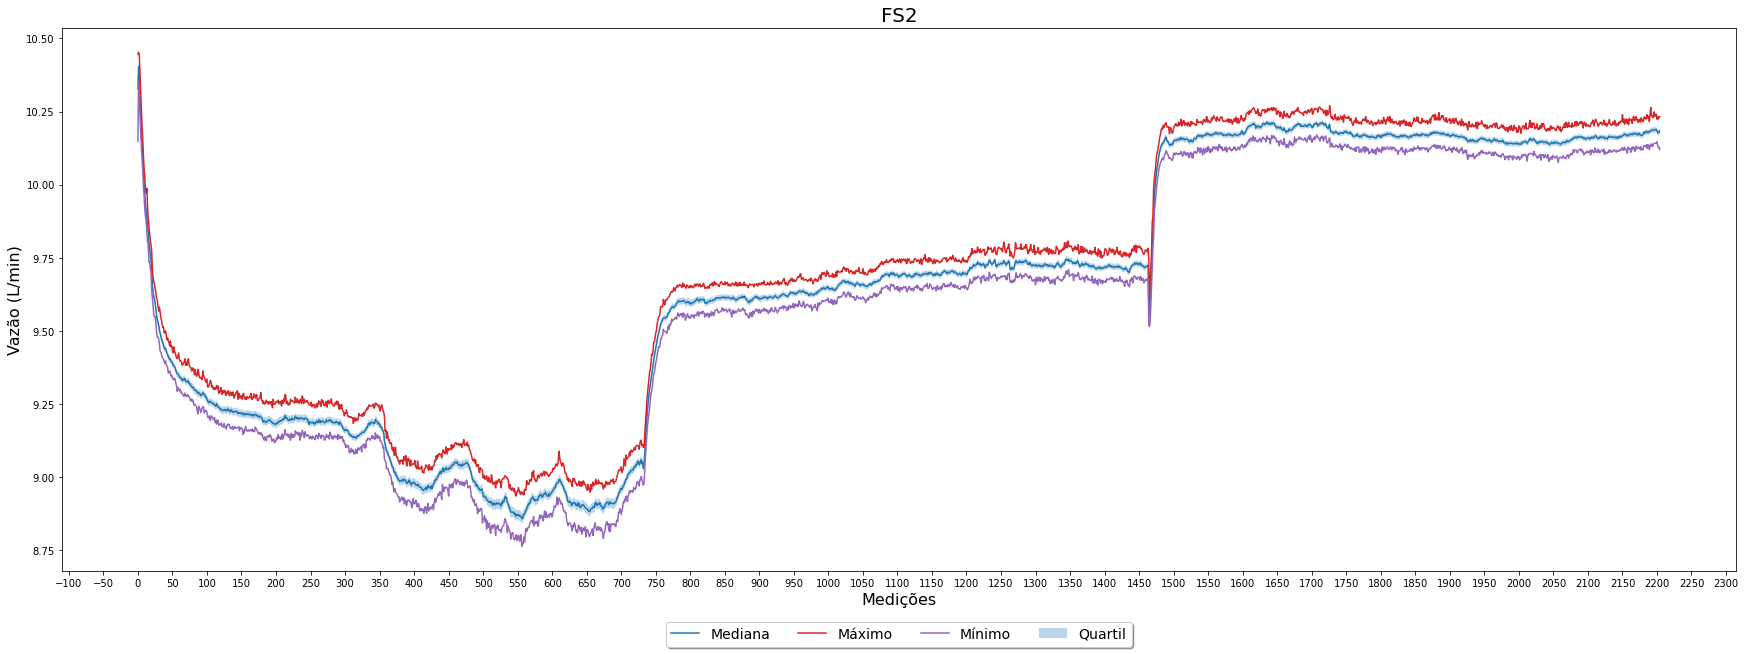

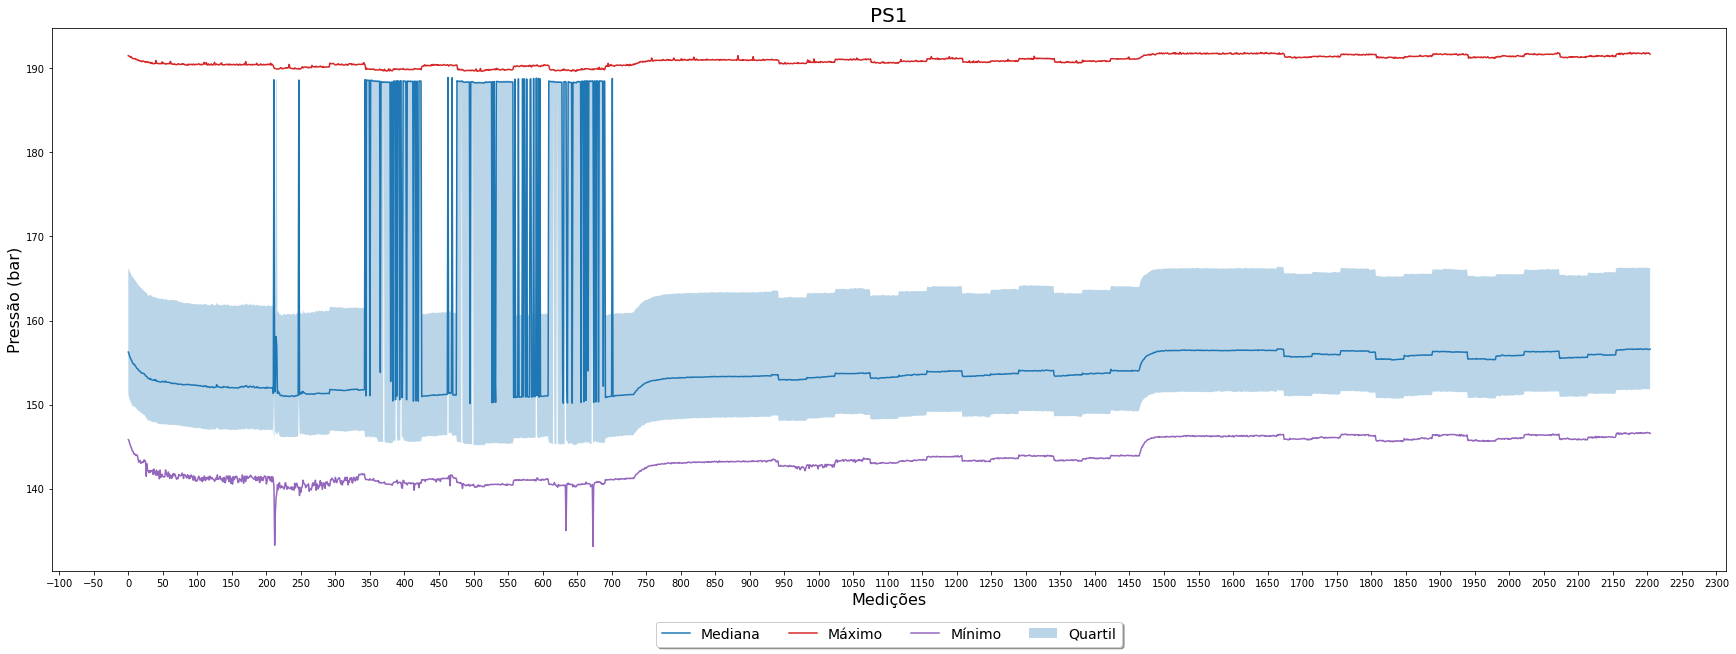

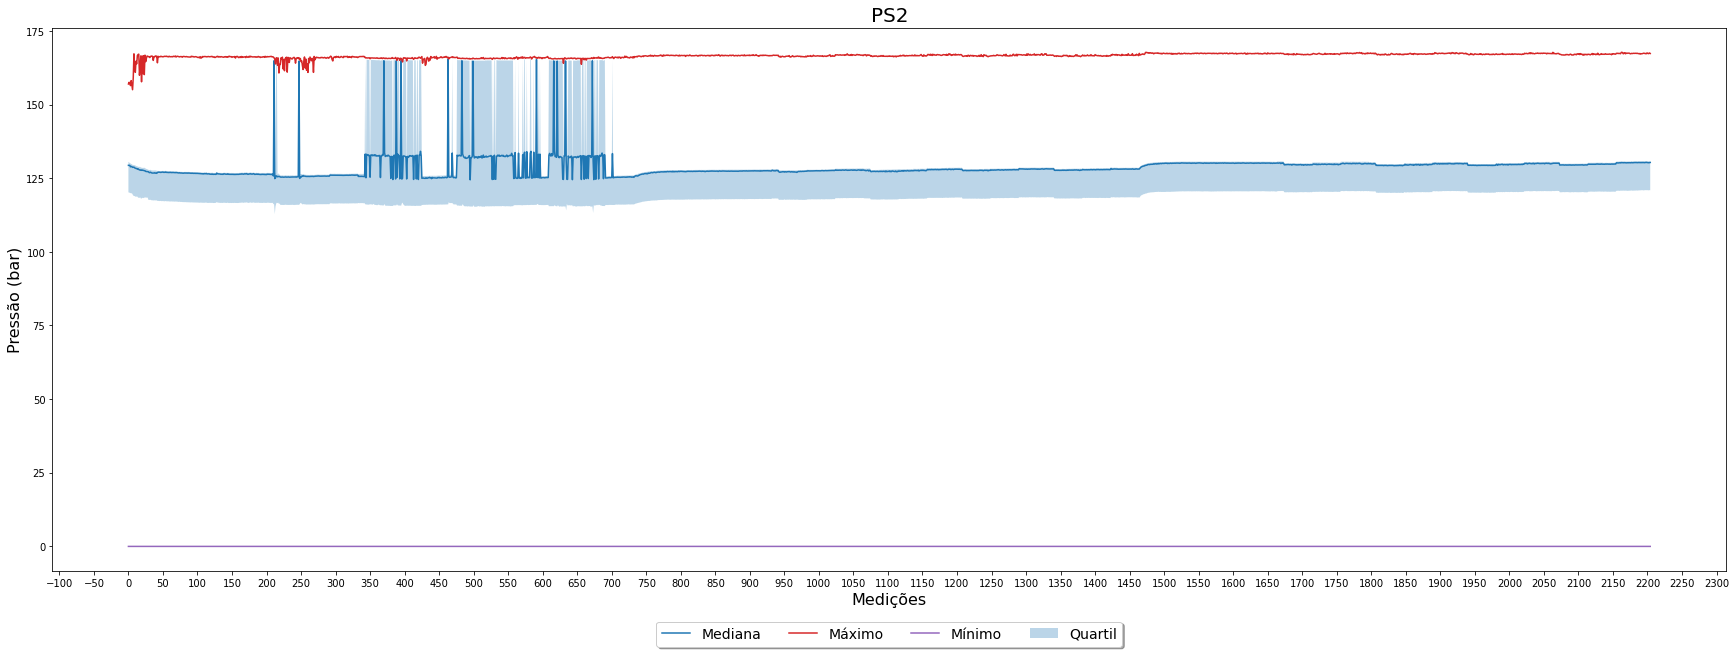

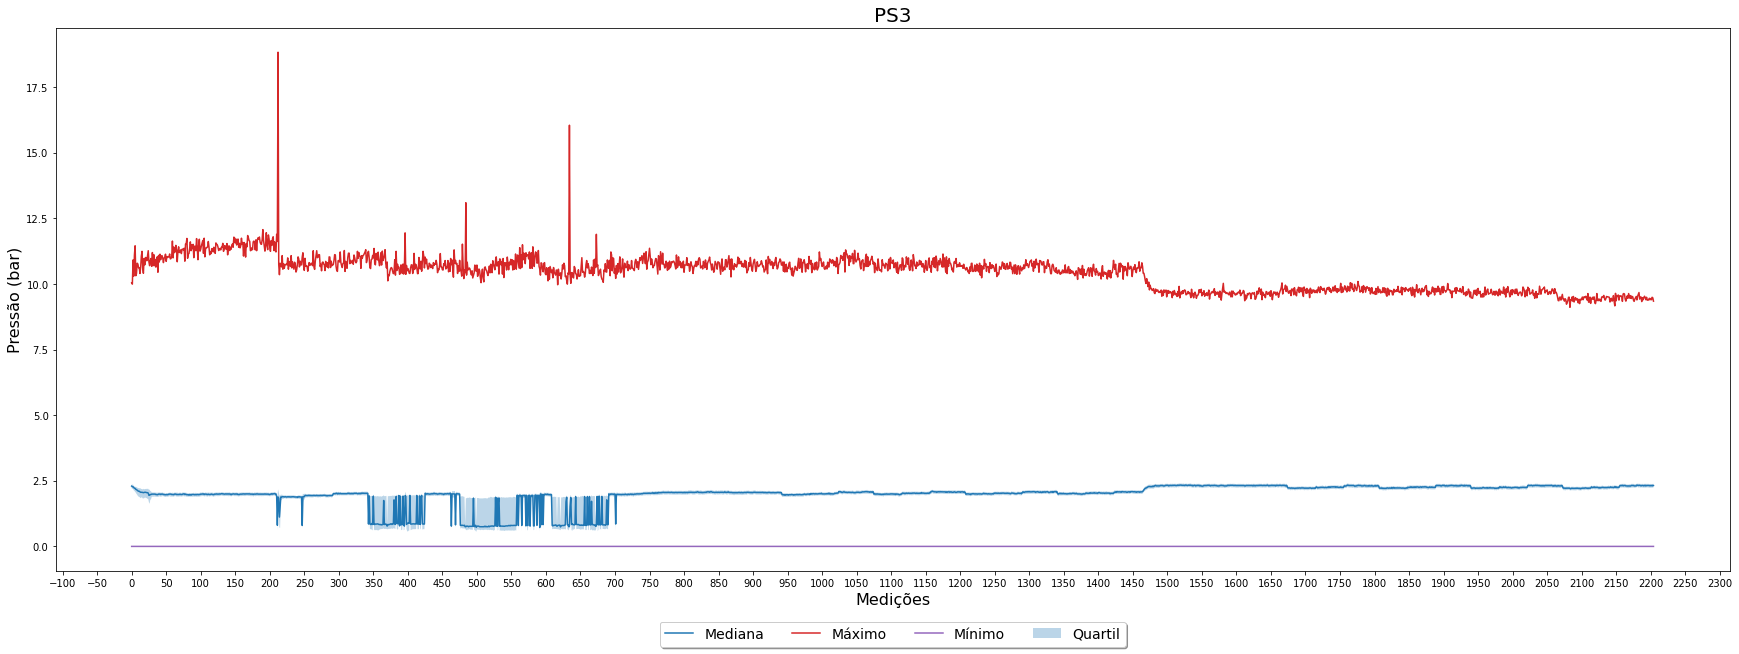

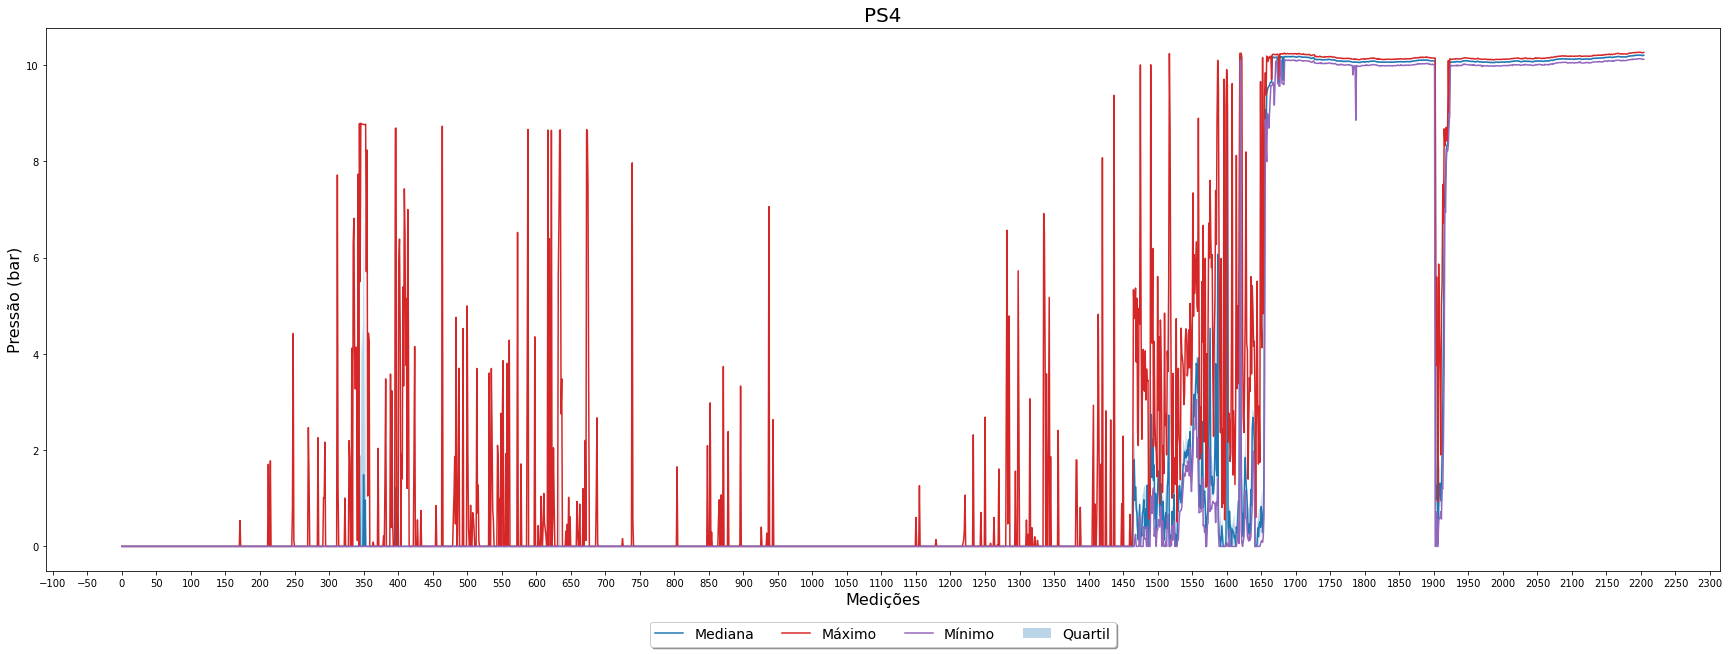

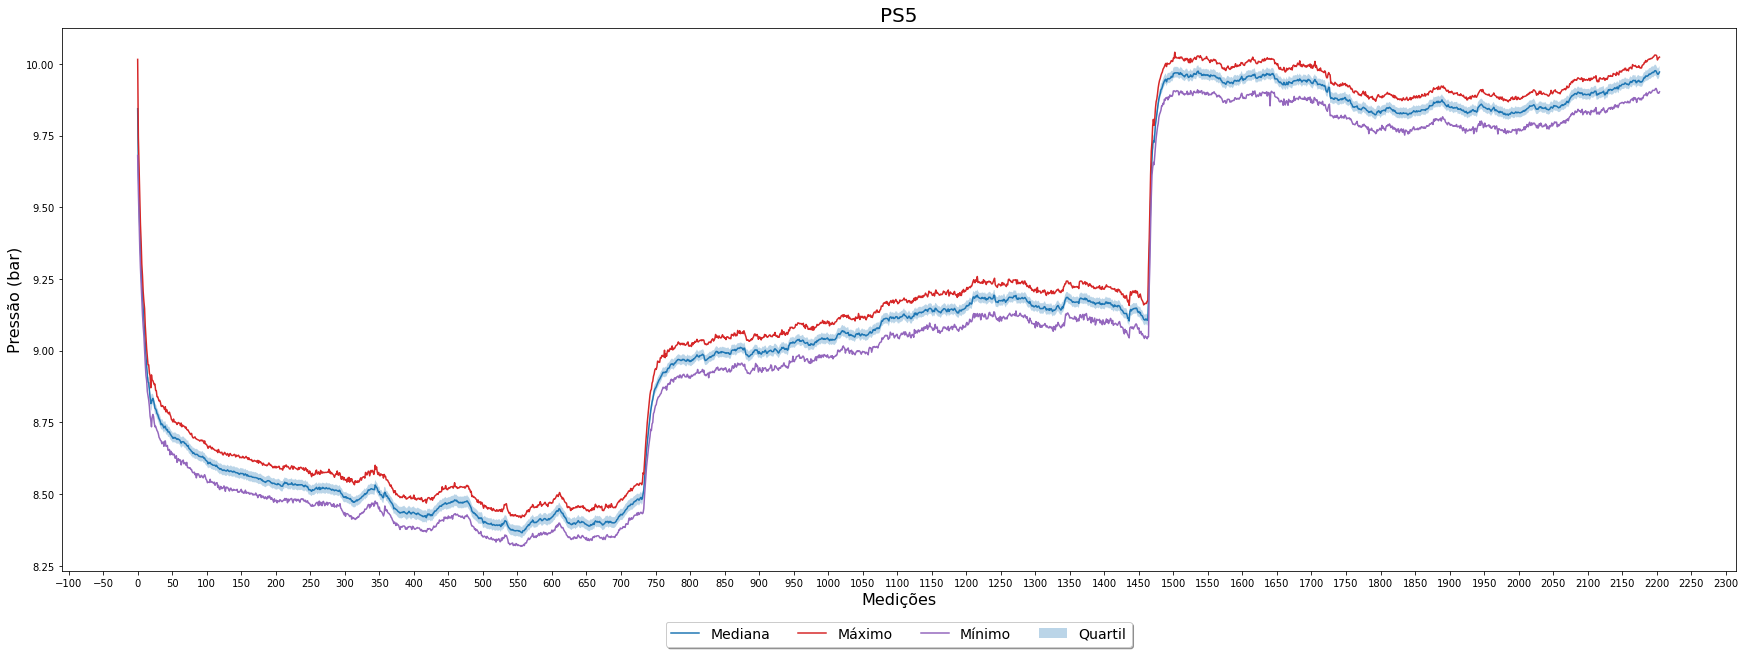

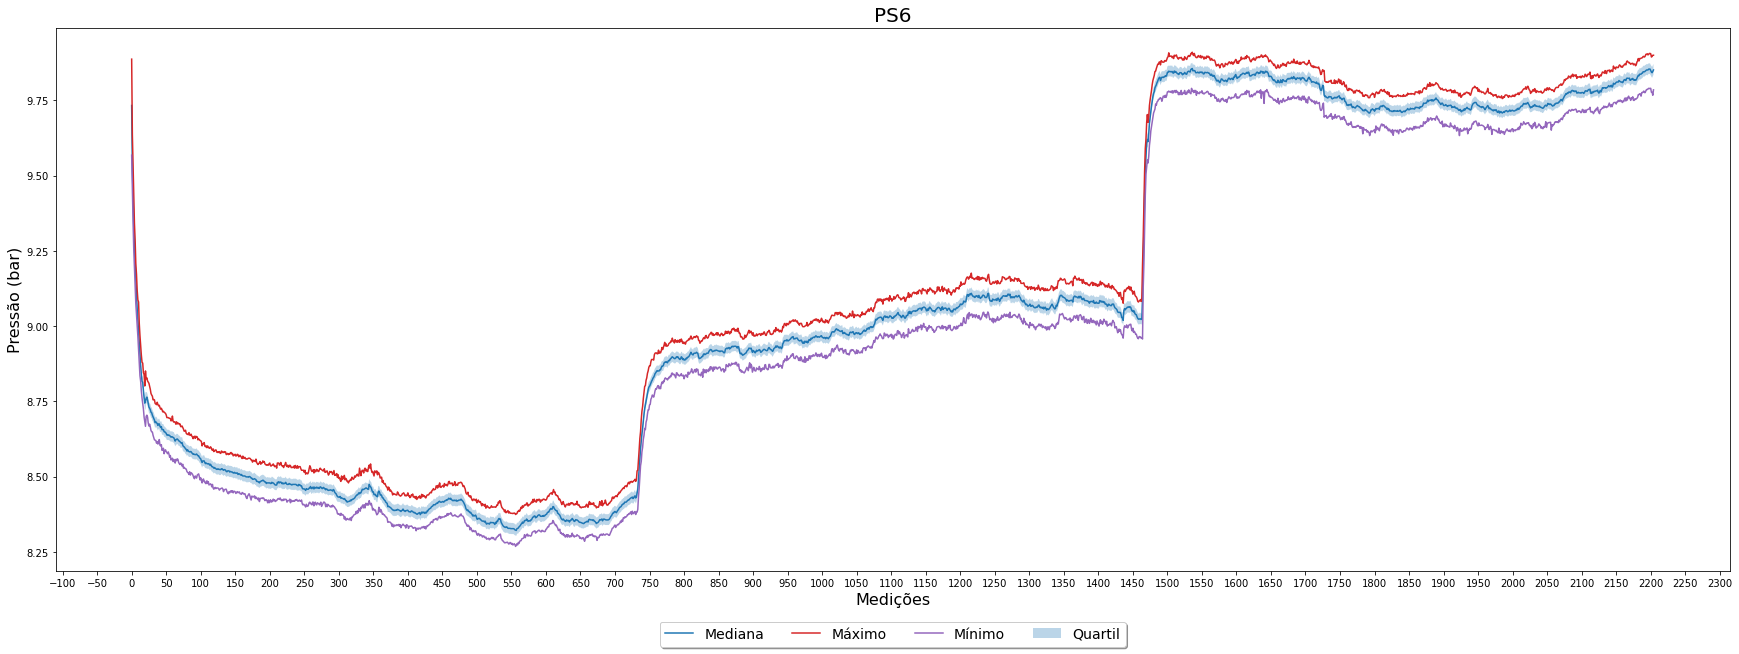

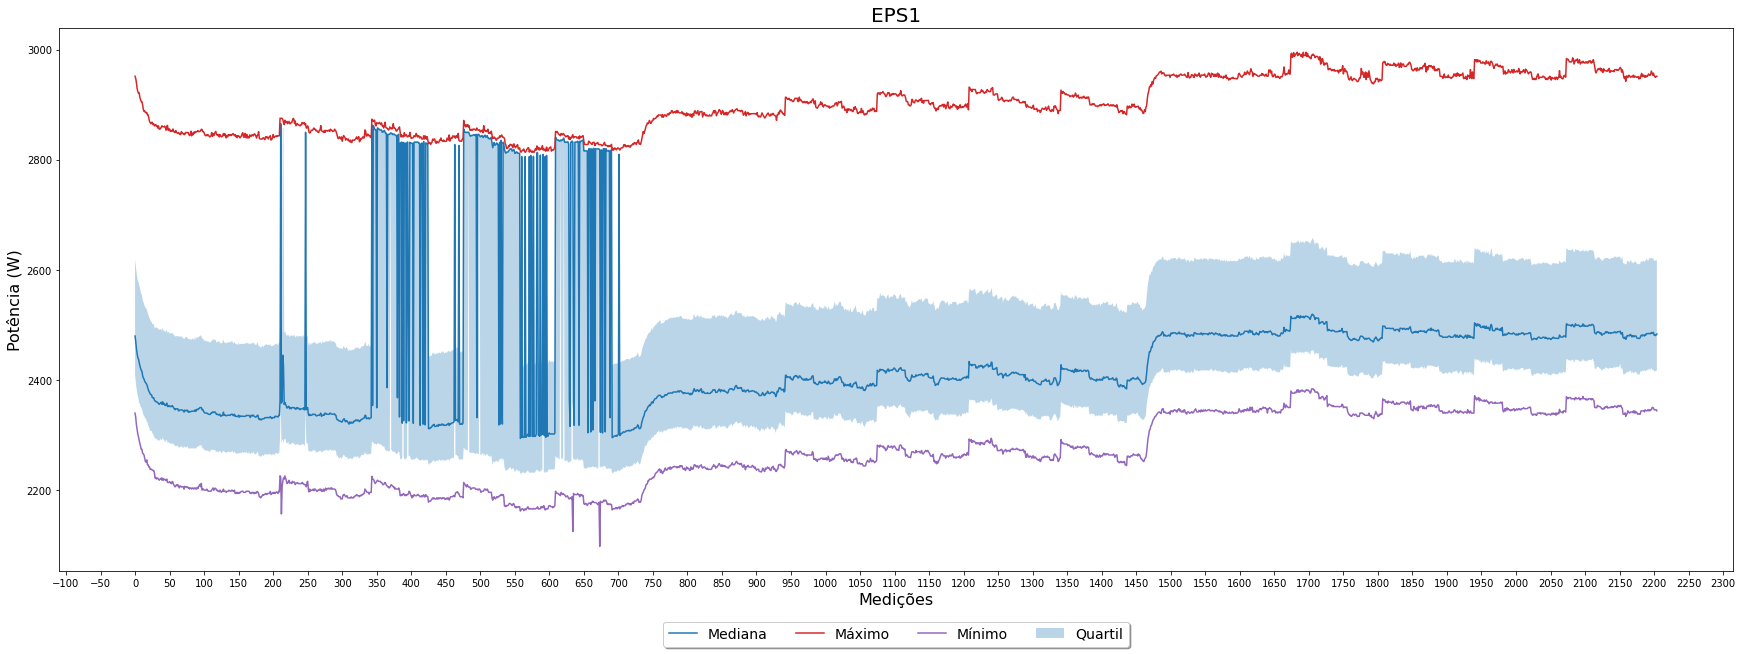

In [ ]:
for c, u in zip(X_dict.keys(), ['Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)',
                                'Vibração (mm/s)', 'Eficiẽncia do Cooler (%)', 'Potência do Cooler (kW)', 'Fator de Eficiência (%)',
                                'Vazão (L/min)', 'Vazão (L/min)',
                                'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)',
                                'Potência (W)']):
    descplot(profile, descricao(X_dict[c]), c, u)

## Retirar  outliers do sistema




In [ ]:
for k, v in X_dict.items():
    print('how nan ' + str(k) + ' = ' + str((X_dict[k].isnull().sum(axis=1) != 0).sum()))

how nan TS1 = 0
how nan TS2 = 0
how nan TS3 = 0
how nan TS4 = 0
how nan VS1 = 0
how nan CE = 0
how nan CP = 0
how nan SE = 0
how nan FS1 = 0
how nan FS2 = 0
how nan PS1 = 0
how nan PS2 = 0
how nan PS3 = 0
how nan PS4 = 0
how nan PS5 = 0
how nan PS6 = 0
how nan EPS1 = 0


In [ ]:
def fill_outliers(data, k):
  datanew = data.copy()
  Q1 = np.quantile(datanew.to_numpy().flatten(), .25)
  Q3 = np.quantile(datanew.to_numpy().flatten(), .75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR

  for c in datanew.columns:
    # https://stackoverflow.com/questions/53806570/why-does-one-use-of-iloc-give-a-settingwithcopywarning-but-the-other-doesnt
    datanew.iloc[(datanew[c] < lower)|(datanew[c] > upper), datanew.columns.get_loc(c)] = np.nan

  print('how outliers ' + str(k) + ' = ' + str(datanew.isnull().sum().sum()))

  datanew = datanew.T.fillna(datanew.mean(axis=1)).T # preenchendo com a media
  return datanew

In [ ]:
for k, v in X_dict.items():
    X_dict[k] = fill_outliers(v, k)

how outliers TS1 = 0
how outliers TS2 = 0
how outliers TS3 = 0
how outliers TS4 = 0
how outliers VS1 = 804600
how outliers CE = 0
how outliers CP = 0
how outliers SE = 2607800
how outliers FS1 = 3339390
how outliers FS2 = 0
how outliers PS1 = 1131463
how outliers PS2 = 2792885
how outliers PS3 = 3112007
how outliers PS4 = 3101012
how outliers PS5 = 0
how outliers PS6 = 0
how outliers EPS1 = 0


In [ ]:
for k, v in X_dict.items():
    print('how nan ' + str(k) + ' = ' + str((X_dict[k].isnull().sum(axis=1) != 0).sum()))

how nan TS1 = 0
how nan TS2 = 0
how nan TS3 = 0
how nan TS4 = 0
how nan VS1 = 0
how nan CE = 0
how nan CP = 0
how nan SE = 0
how nan FS1 = 0
how nan FS2 = 0
how nan PS1 = 0
how nan PS2 = 0
how nan PS3 = 0
how nan PS4 = 503
how nan PS5 = 0
how nan PS6 = 0
how nan EPS1 = 0


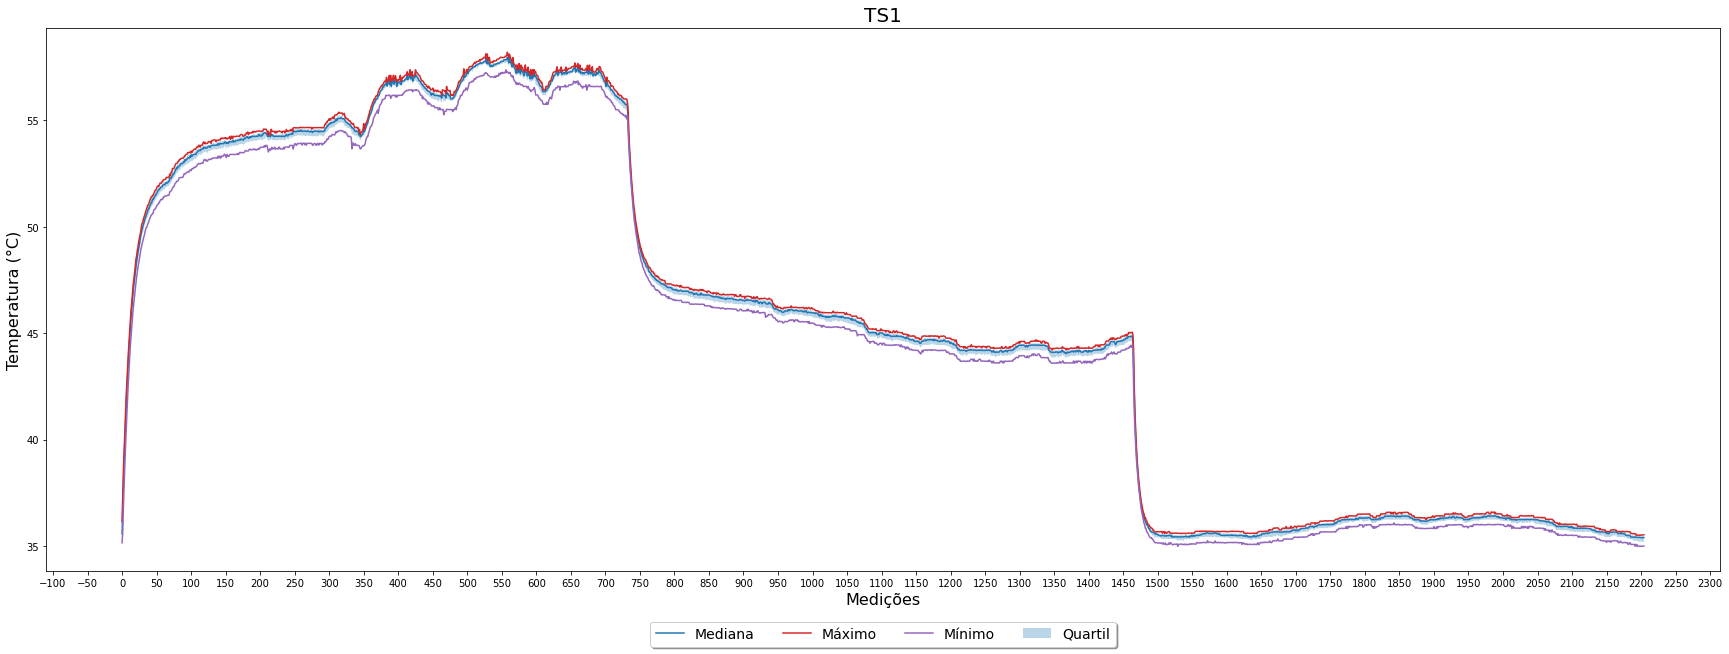

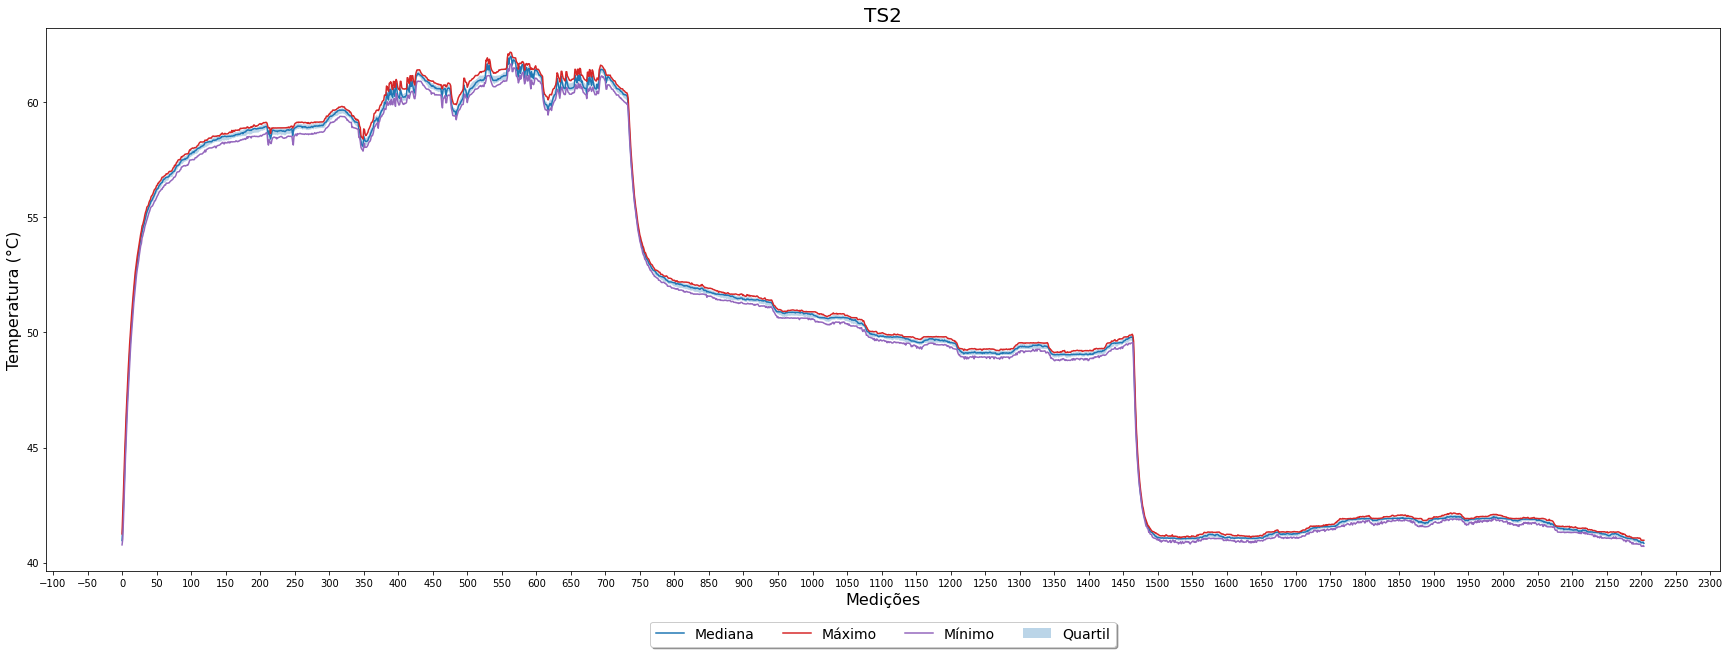

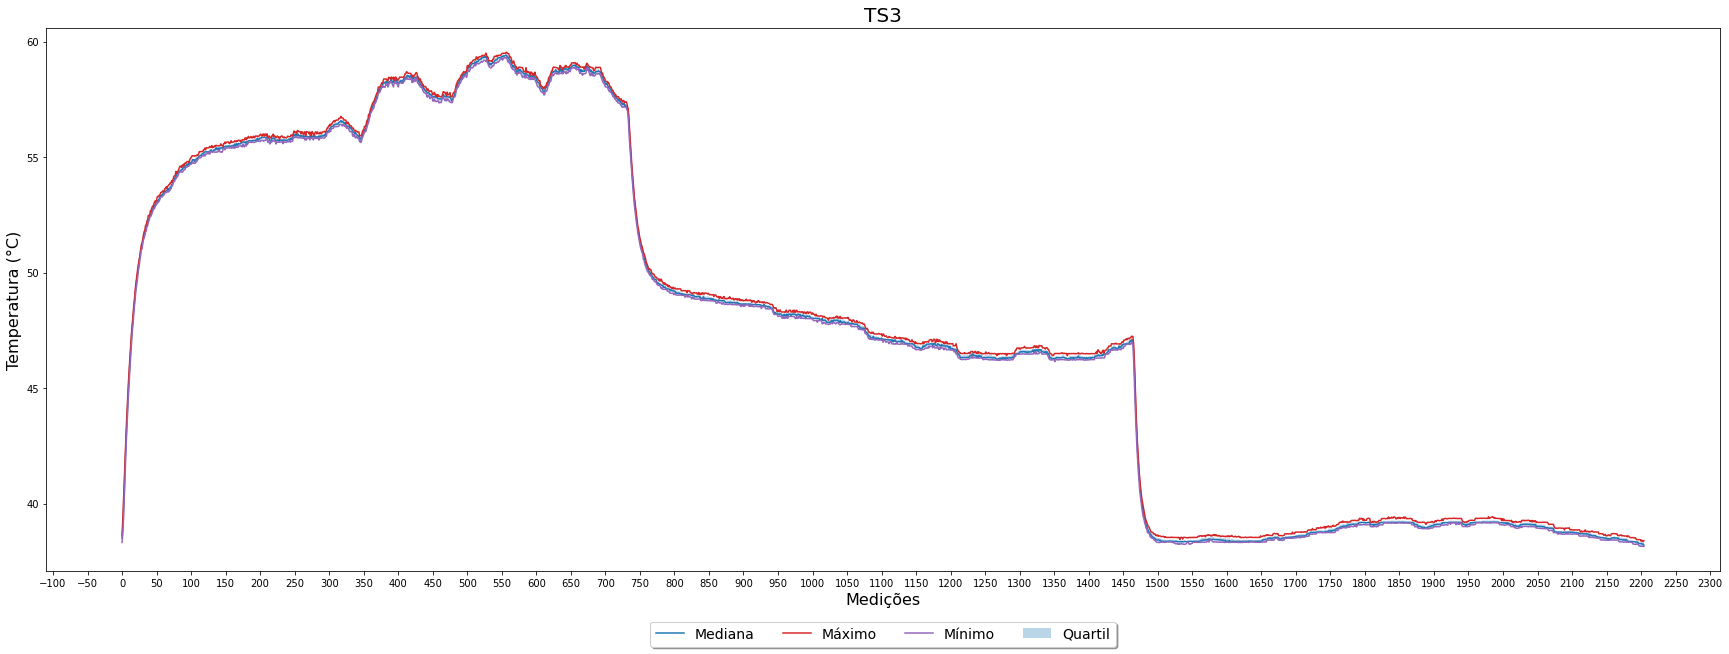

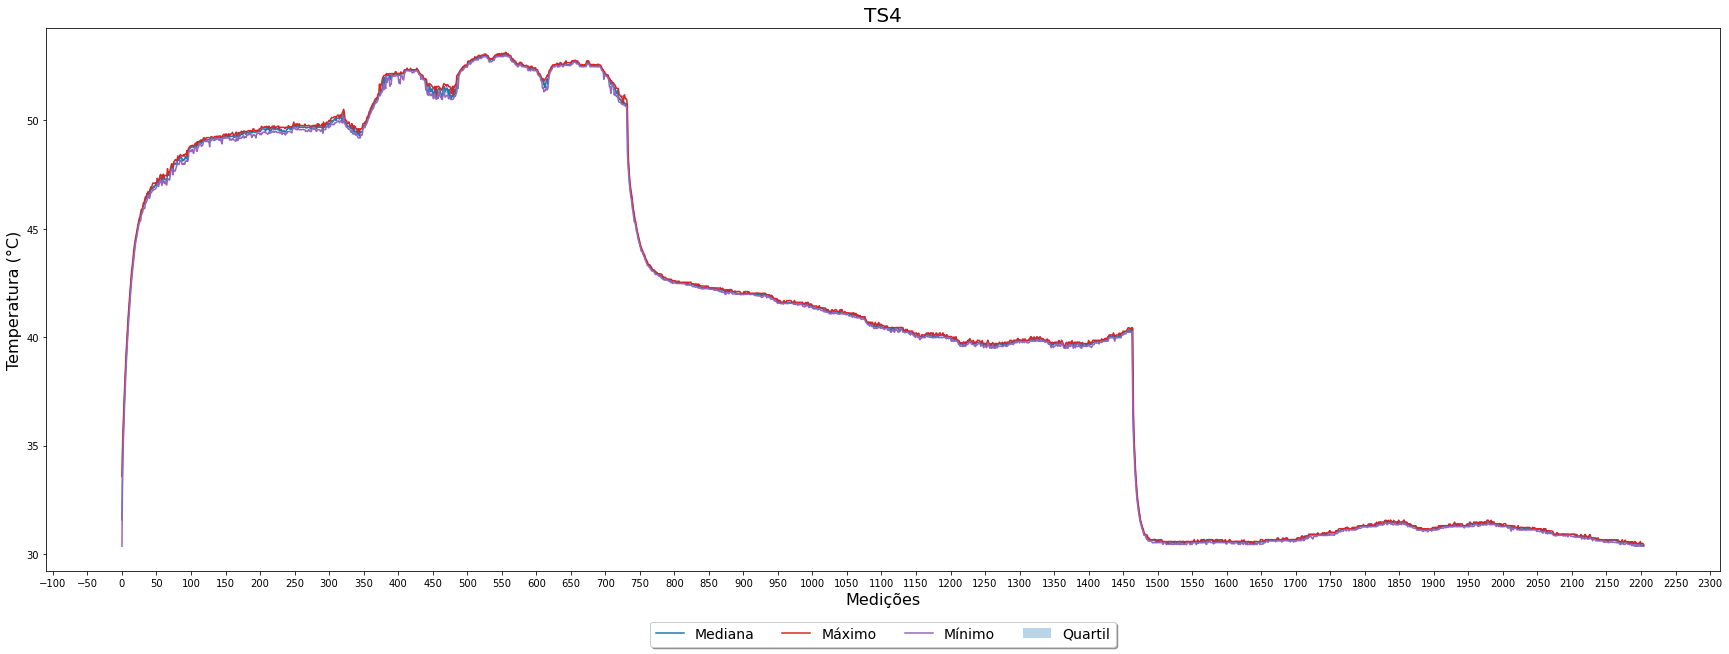

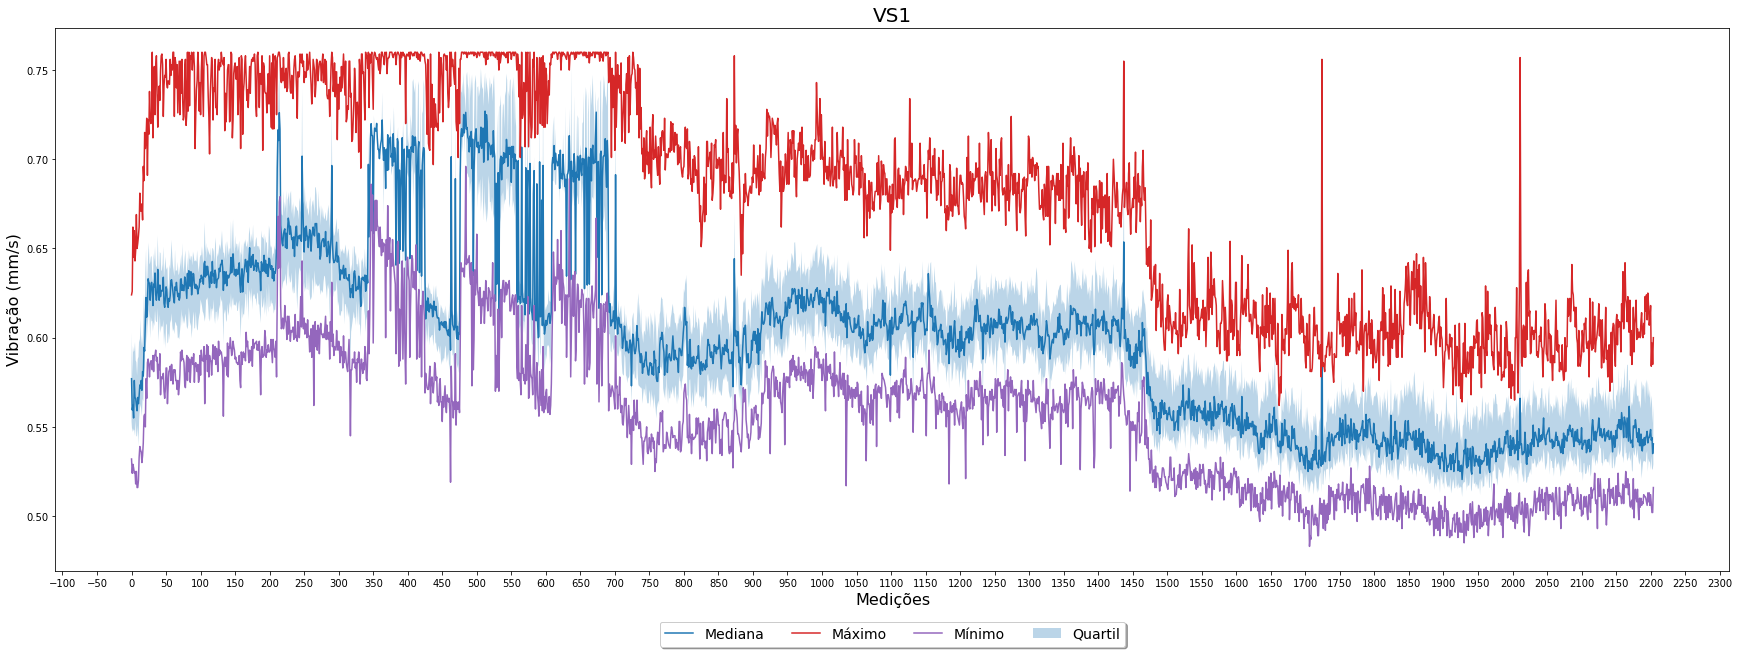

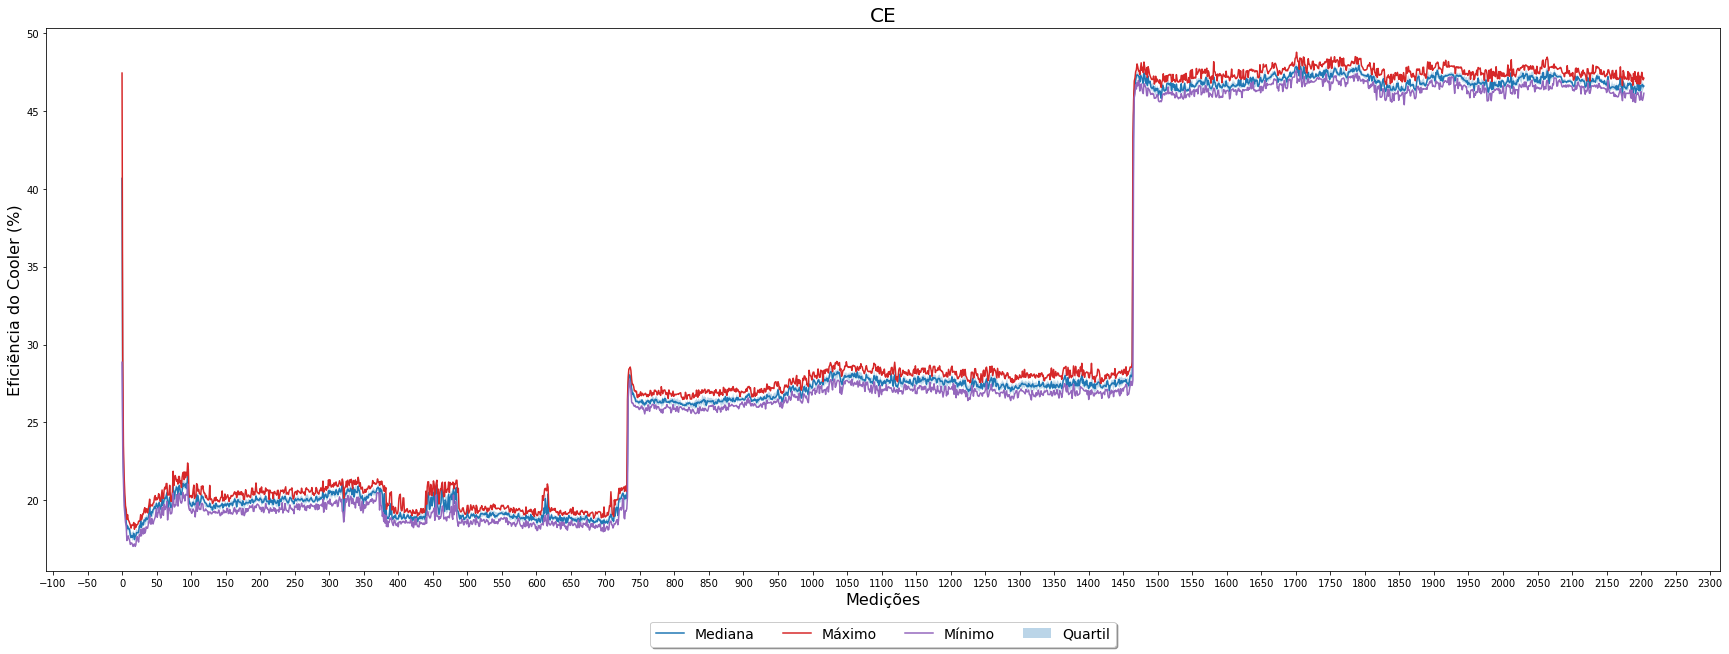

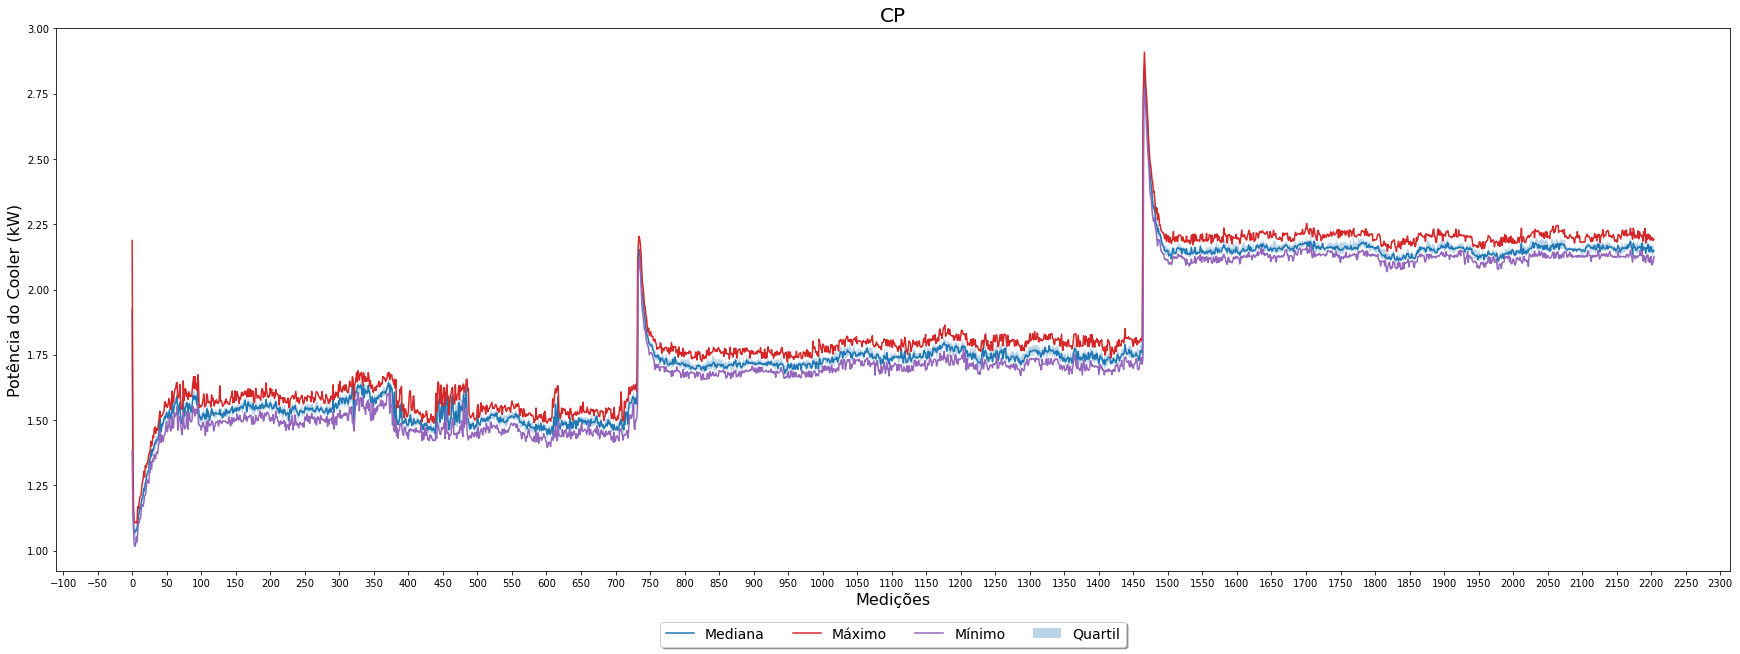

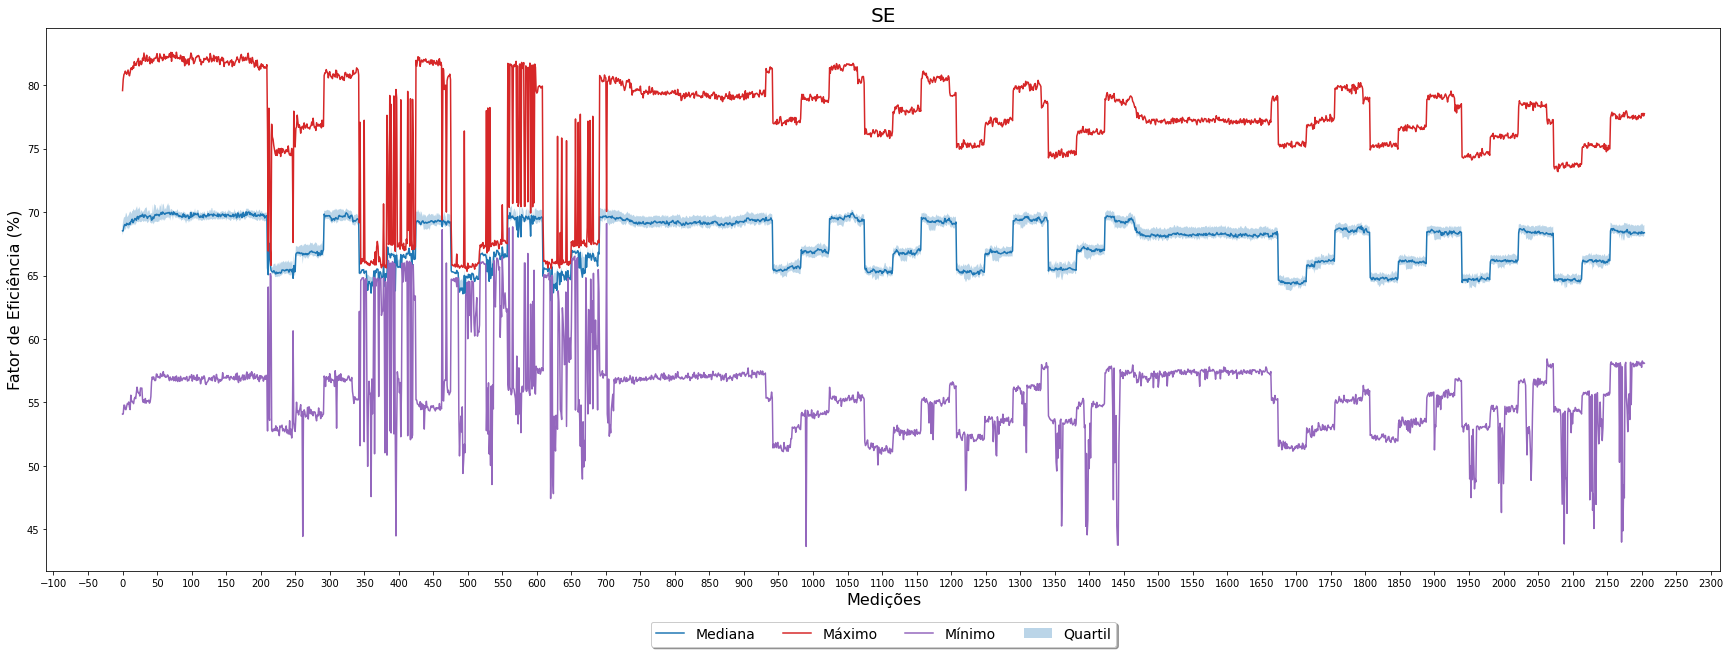

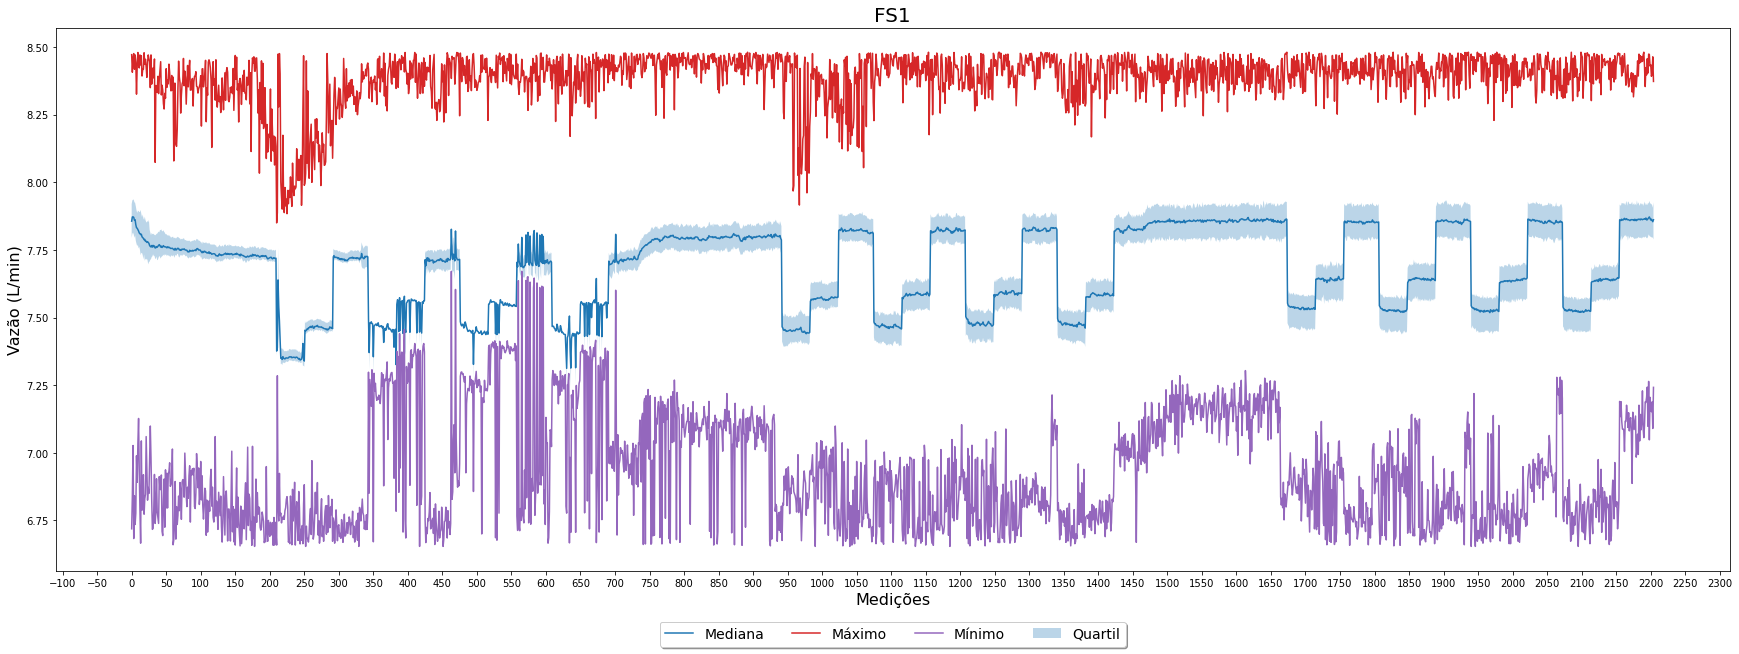

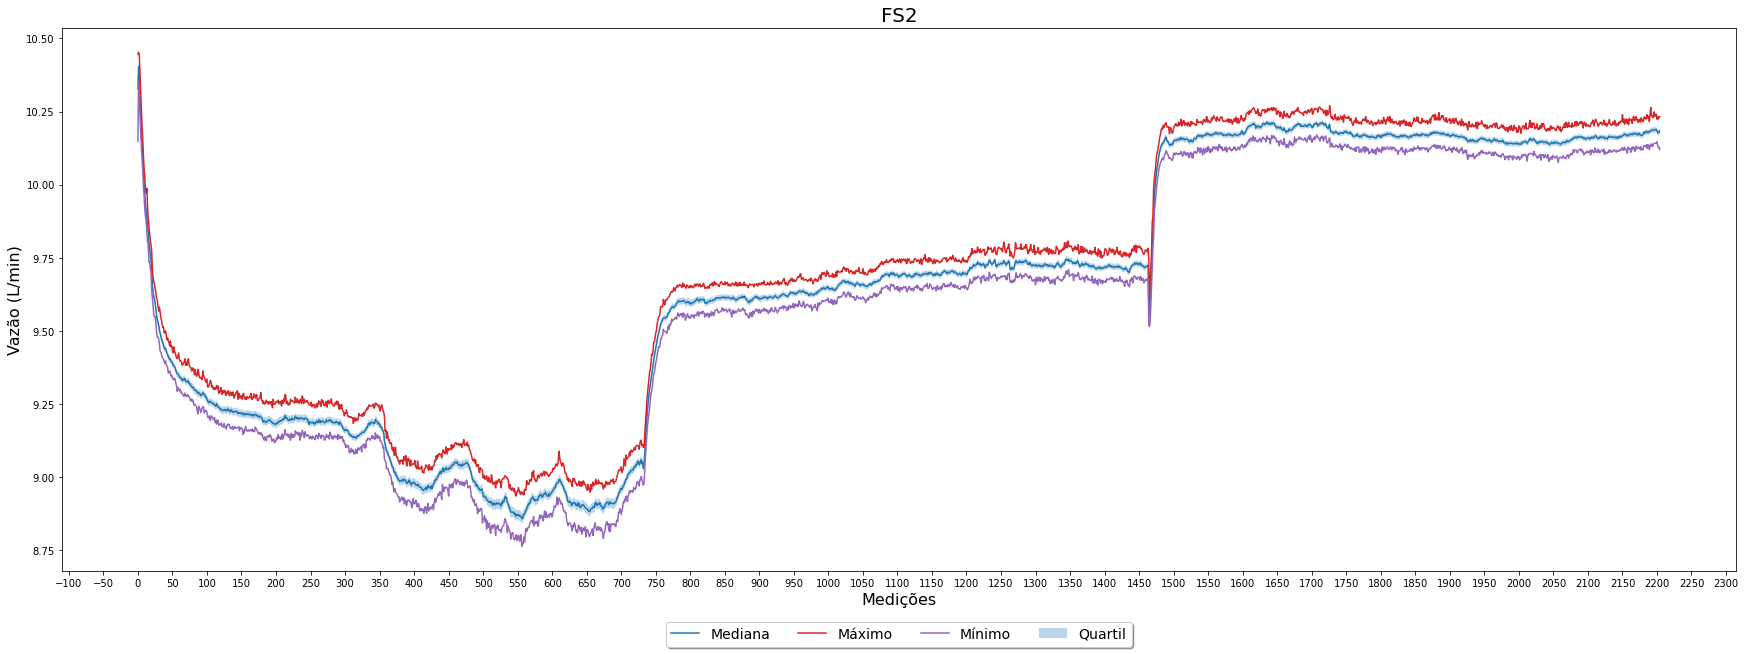

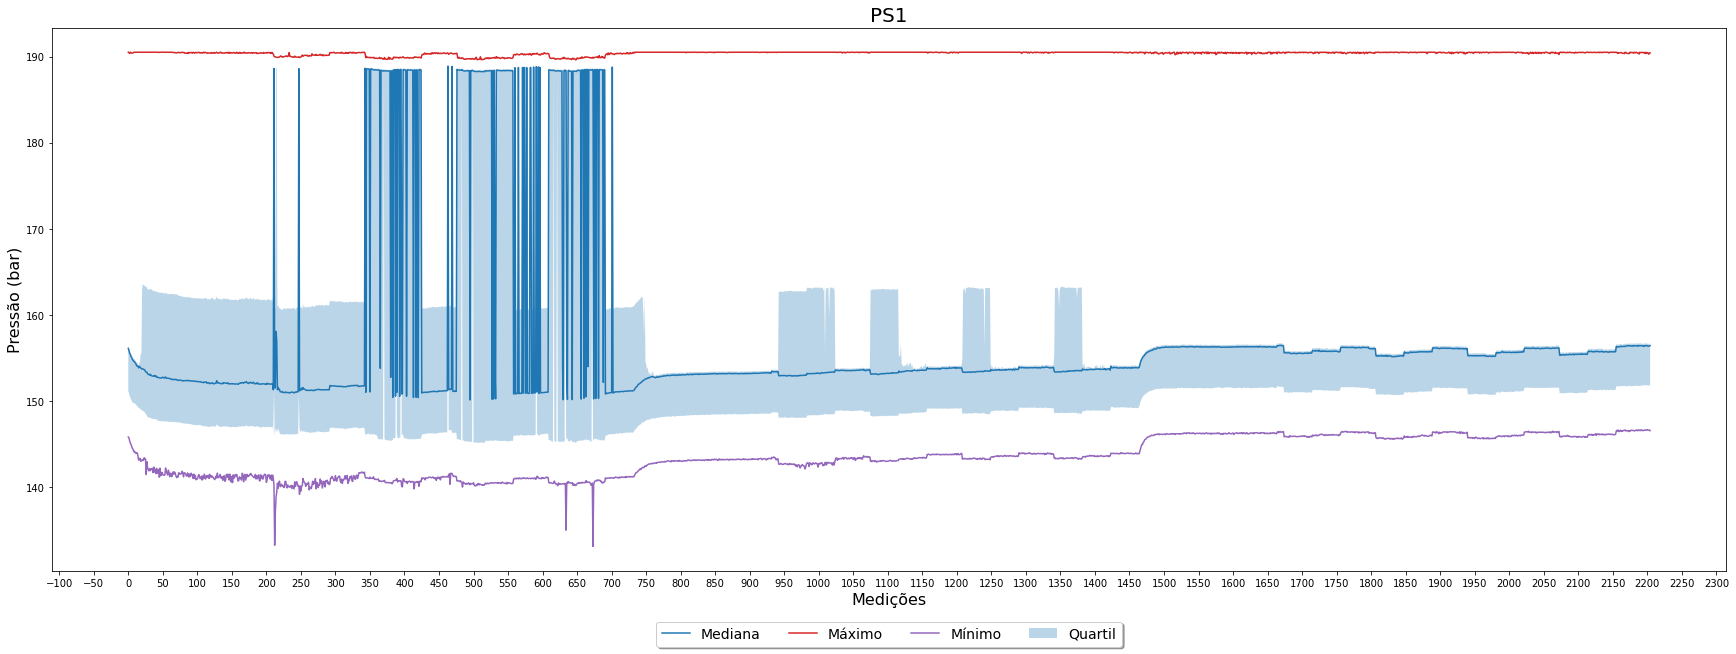

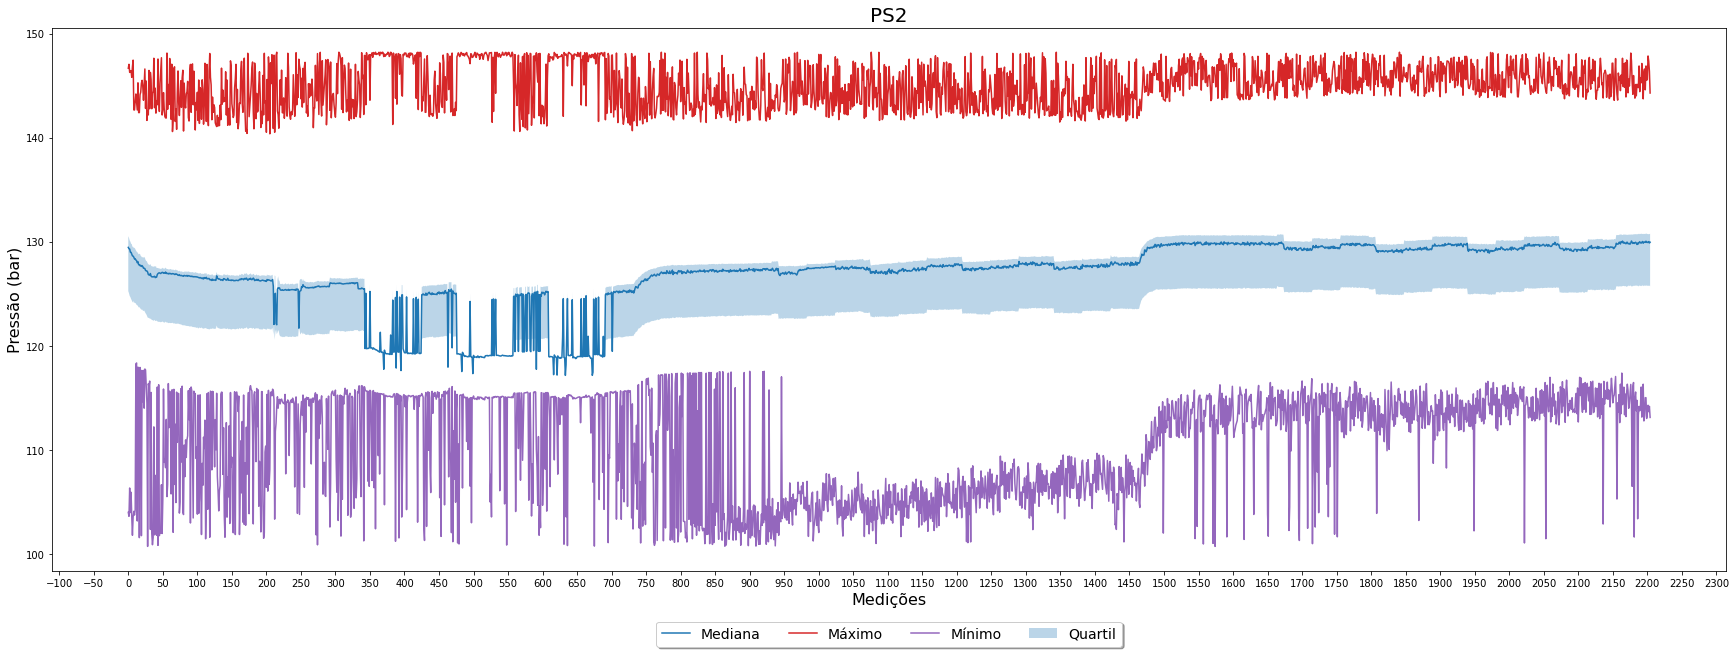

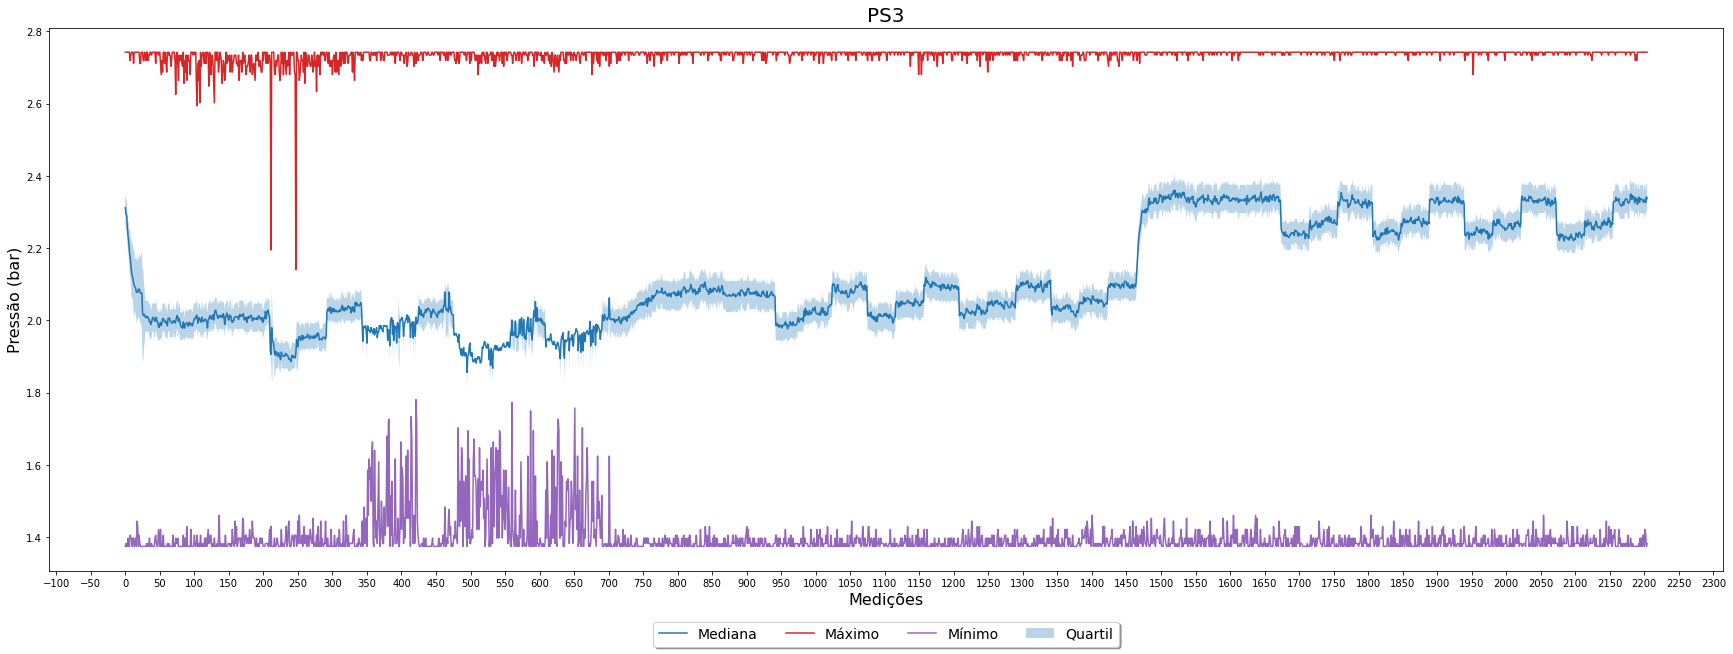

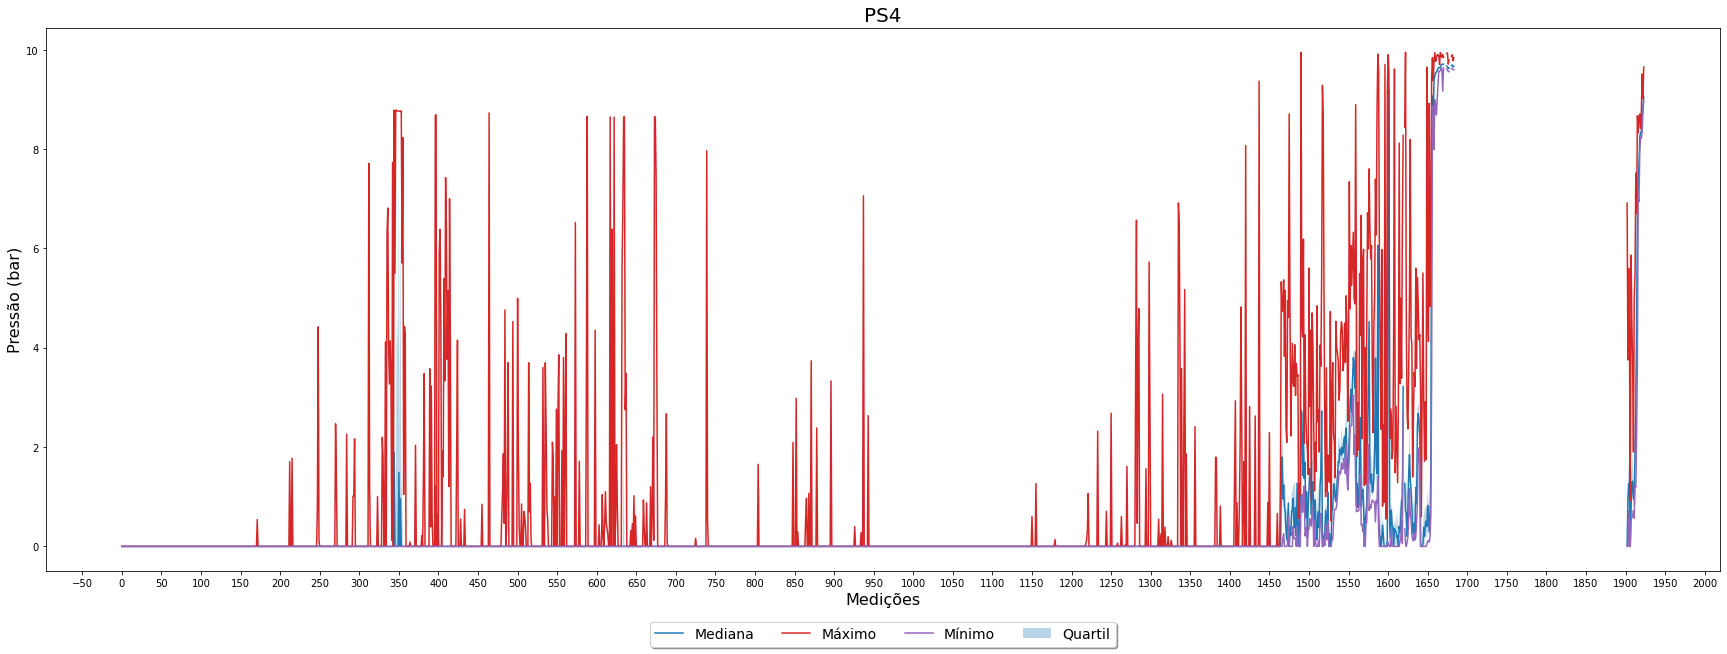

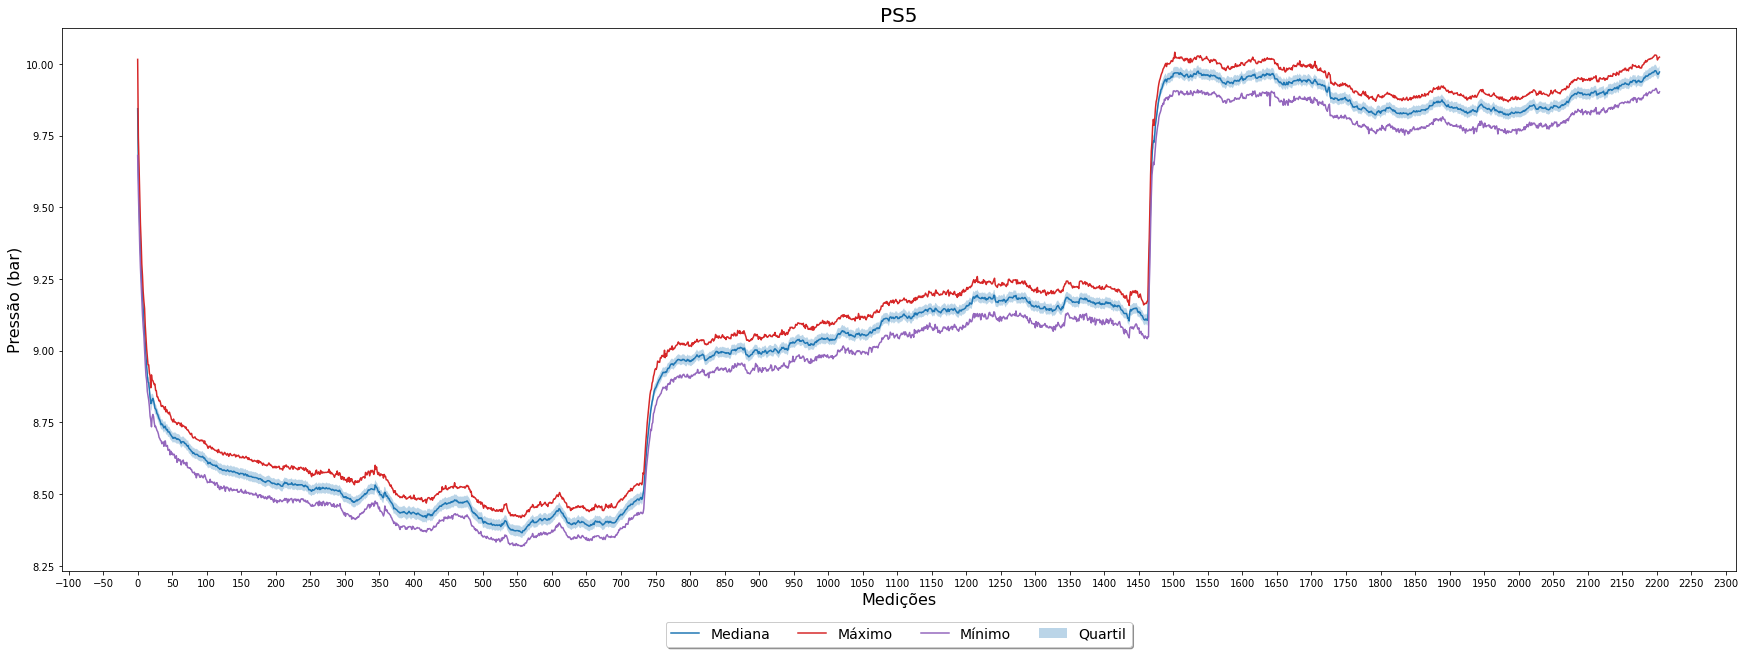

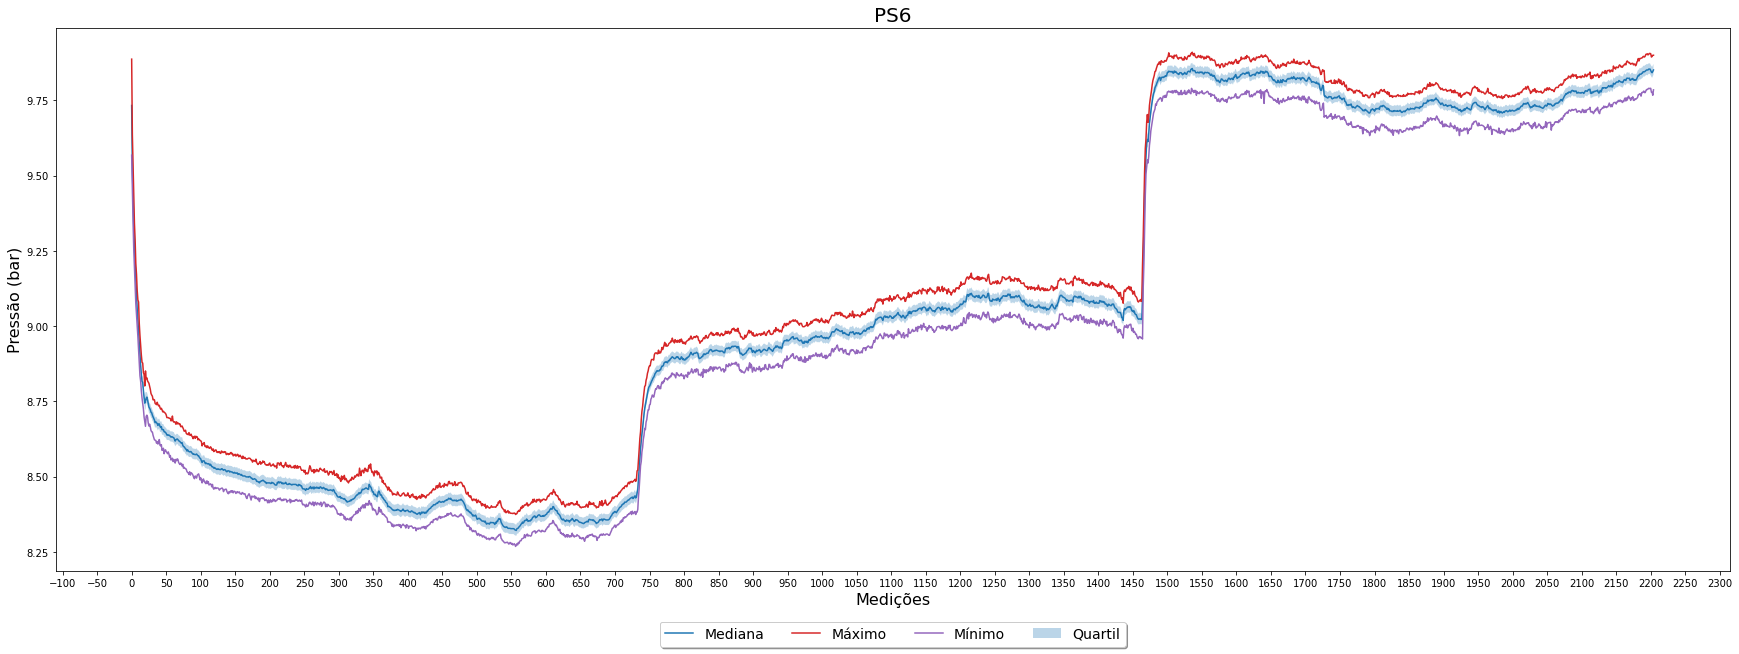

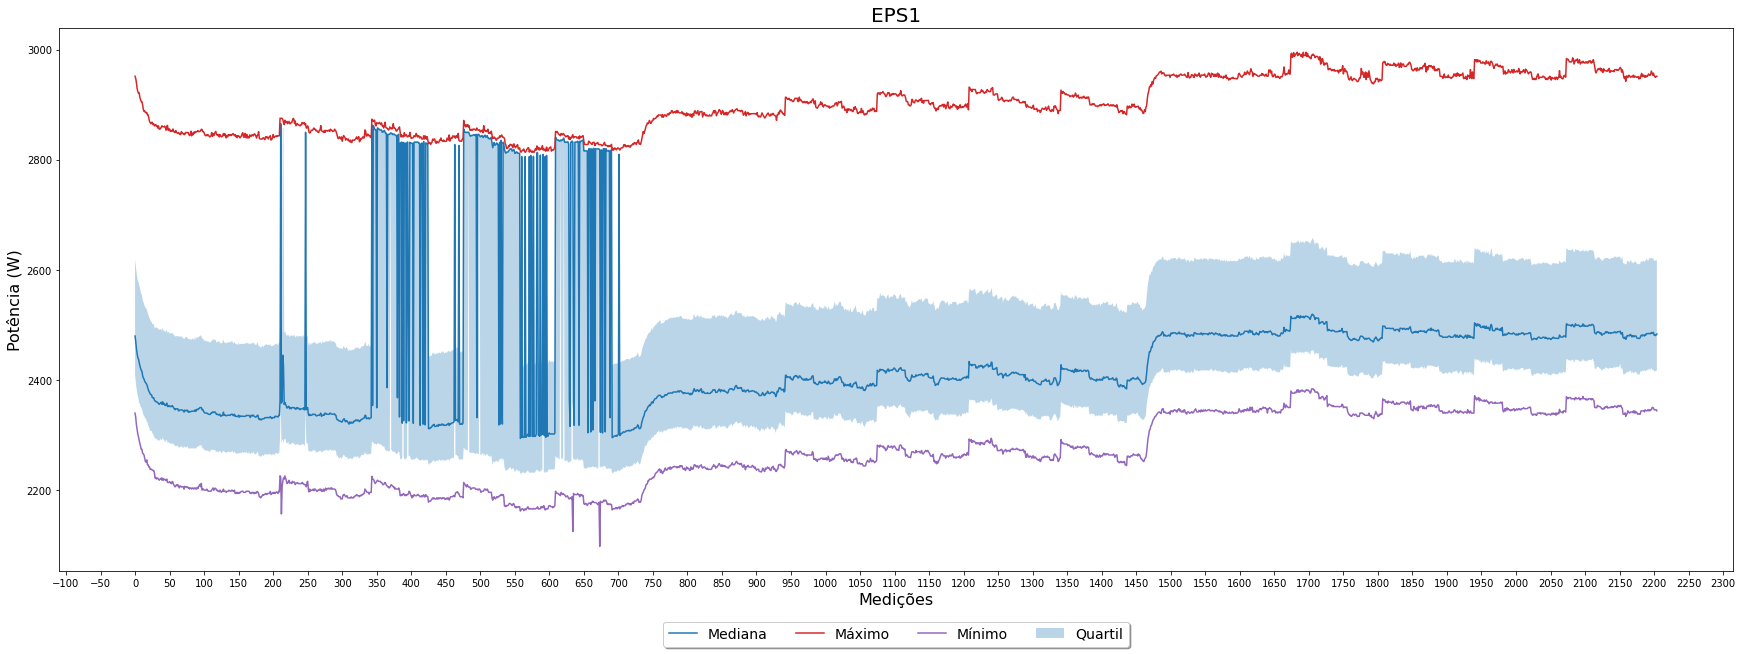

In [ ]:
# após outliers removidos temos:
for c, u in zip(X_dict.keys(), ['Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)', 'Temperatura (°C)',
                                'Vibração (mm/s)', 'Eficiẽncia do Cooler (%)', 'Potência do Cooler (kW)', 'Fator de Eficiência (%)',
                                'Vazão (L/min)', 'Vazão (L/min)',
                                'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)', 'Pressão (bar)',
                                'Potência (W)']):
    descplot(profile, descricao(X_dict[c]), c, u)

## Colunas estatísticas

In [ ]:
def stat(data):  
    md = data.mean(axis=1)
    max = data.max(axis=1)
    min = data.min(axis=1)
    var = data.var(axis=1)
    med = data.median(axis=1)
    skew = data.skew(axis=1)
    kurt = data.kurt(axis=1)
    data_stat = pd.concat([md, max, min, var, med, skew, kurt], axis=1)
    data_stat.columns = ["Media","Max", "Min","Var","Mediana","Assimetria","Curtose"]
    return data_stat

In [ ]:
X_stat = {}
for (k,v) in X_dict.items():
    X_stat[k] = stat(v)

## Correlação

Correlação entre os sensores e a variavel objetivo (profile) <br>
SENSORES: **'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE', 'FS1', 'FS2', 'PS1', 'PS2','PS3', 'PS4', 'PS5', 'PS6', 'EPS1'**


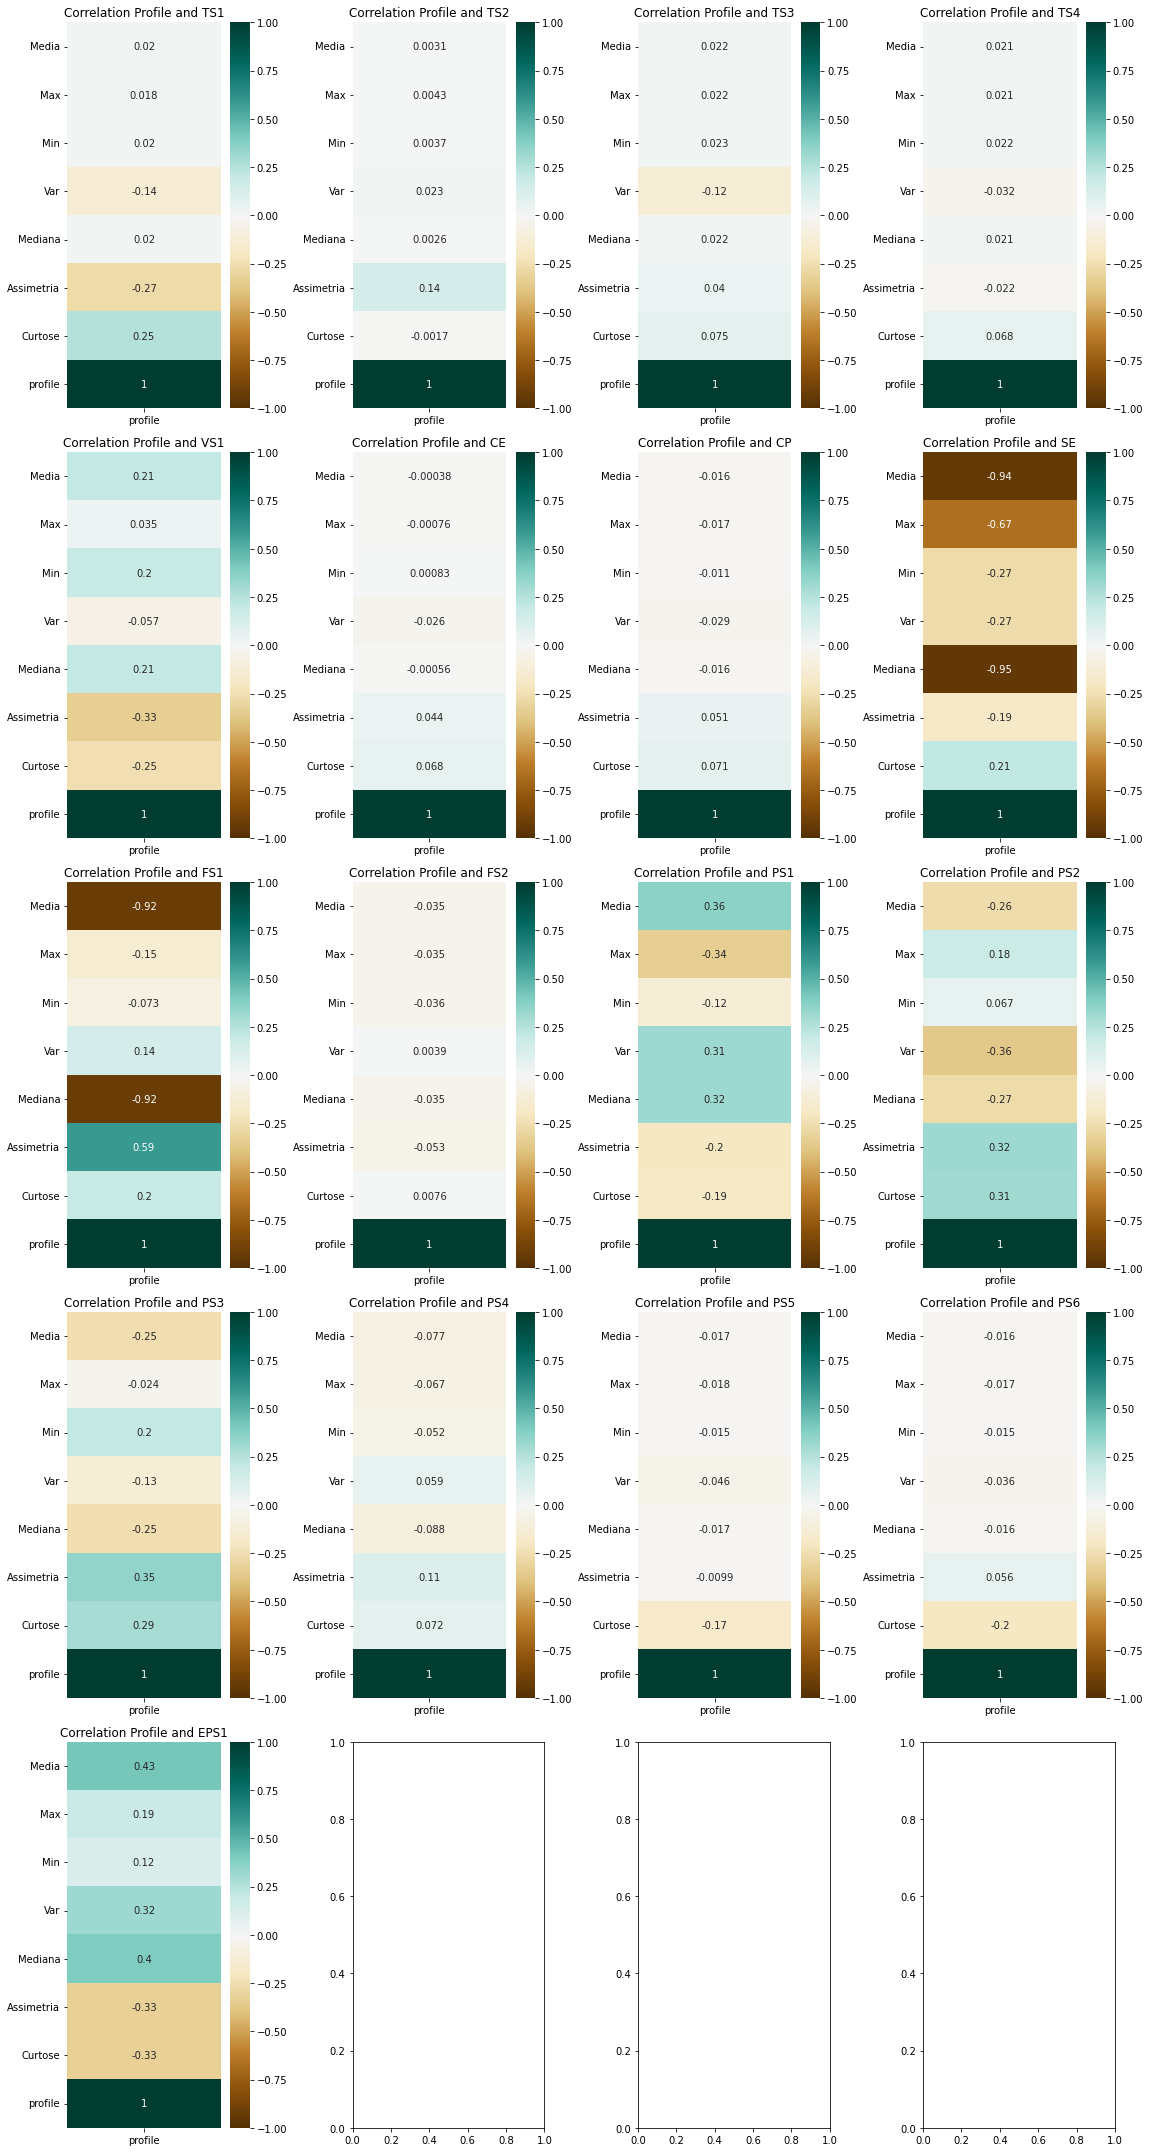

In [ ]:
# k é o que está entre '' e v é o valor
fig, axs = plt.subplots(5, 4, figsize=(16, 30))
for (k,v), ax in zip(X_stat.items(), axs.reshape(-1)):
    sns.heatmap(v.assign(profile=profile).corr()[['profile']], vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)
    ax.set_title('Correlation Profile and ' + k);
plt.tight_layout()
plt.show()

Pelas correlações, as variáveis 

TS1: linha da bomba e correlação > 0,1

TS2: linha da bomba

VS1: correlação

SE: correlação

FS1: correlação e linha da bomba

PS1, PS2, PS3: correlação e liha da bomba

EPS1: correlação

In [ ]:
X_final = pd.concat([X_stat['TS1'], X_stat['TS2'], X_stat['VS1'],
                     X_stat['SE'], X_stat['FS1'], X_stat['EPS1'],
                     X_stat['PS1'], X_stat['PS2'], X_stat['PS1']], axis=1)
X_final = X_final.to_numpy()
X_final

array([[ 35.62198333,  36.152     ,  35.156     , ..., 156.12      ,
          1.09049572,   2.73076923],
       [ 36.67696667,  37.488     ,  35.648     , ..., 155.88      ,
          0.89194784,   1.91883882],
       [ 37.8808    ,  38.621     ,  36.879     , ..., 155.56      ,
          0.91935666,   1.99048657],
       ...,
       [ 35.31918333,  35.52      ,  34.984     , ..., 156.39      ,
          0.83630692,   1.76936042],
       [ 35.32476667,  35.531     ,  35.        , ..., 156.41      ,
          0.85383766,   1.8519039 ],
       [ 35.32223333,  35.531     ,  35.008     , ..., 156.44      ,
          0.8381724 ,   1.81232978]])

In [ ]:
y_final = profile.to_numpy()
y_final = y_final.reshape(-1, 1)
y_final

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
print(X_final.shape)
print(y_final.shape)

(2205, 63)
(2205, 1)


In [ ]:

from sklearn.datasets import make_classification
X_final, y_final = make_classification(n_samples=100, n_features=100)
import time
import numpy as np
np.random.seed(42)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
n_clusters = len(np.unique(y_final))

models = {
    'KMeans': KMeans(n_clusters=n_clusters),
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant': LinearDiscriminantAnalysis(),
    'Nearest Neighbors': KNeighborsClassifier(),
    'Linear SVM': SVC(kernel='linear', gamma='auto'),
    'Gaussian Process': GaussianProcessClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Net': MLPClassifier(alpha=1, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'Naive Bayes': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis()
}
 
parameters = {
    'Nearest Neighbors': {'n_neighbors': [1, 3, 5, 7]},
    'Linear SVM': {'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]},
    'Decision Tree': {'max_depth': [None, 3, 5, 7]},
    'Random Forest': {'n_estimators': [30, 100, 300]},
    'Neural Net': {'hidden_layer_sizes': [30, 100, 300], 'activation': ['logistic','tanh','relu']},
    'AdaBoost': {'n_estimators': [30, 100, 300]}
}

only_execute = ['KMeans', 'Logistic Regression', 'Linear Discriminant', 'Gaussian Process', 'Naive Bayes', 'QDA']
search_execute = ['Nearest Neighbors', 'Linear SVM', 'Decision Tree', 'Random Forest', 'Neural Net', 'AdaBoost']

In [ ]:
def experimental(X, y):
    ans = {}
    for c in only_execute:
        start = time.process_time()

        pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', models[c])])
        ans[c] = cross_validate(pipeline, X, y, scoring='r2')
        print('Elapsed time of {} is {:.6f} seconds.'.format(c, time.process_time() - start))
        print(ans[c])
        

    for c in search_execute:
        start = time.process_time()

        clf = Pipeline([('transformer', StandardScaler()), 
                        ('estimator', GridSearchCV(models[c], param_grid=parameters[c]))]).fit(X, y) # Grid search
        pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', clf)])
        ans[c] = cross_validate(pipeline, X, y, scoring='r2')
        print('Elapsed time of {} is {:.6f} seconds.'.format(c, time.process_time() - start))
        print(ans[c])

    return ans

In [ ]:
ans = experimental(X_final, y_final)

Elapsed time of KMeans is 0.132715 seconds.
{'fit_time': array([0.03591347, 0.02199054, 0.02177215, 0.02224565, 0.02256703]), 'score_time': array([0.00116968, 0.00094962, 0.00084329, 0.00083685, 0.00087452]), 'test_score': array([-0.31868132, -0.6       , -2.2       , -0.61616162, -0.04166667])}
Elapsed time of Logistic Regression is 0.044577 seconds.
{'fit_time': array([0.01328254, 0.00685596, 0.00654364, 0.00734639, 0.00669384]), 'score_time': array([0.00068426, 0.00112796, 0.00058031, 0.0005796 , 0.00057721]), 'test_score': array([ 0.2, -0.6,  0. ,  0.8, -0.4])}
Elapsed time of Linear Discriminant is 0.085541 seconds.
{'fit_time': array([0.03759623, 0.00715709, 0.00716901, 0.00735569, 0.00857568]), 'score_time': array([0.00112891, 0.0008924 , 0.00087929, 0.00281358, 0.00092816]), 'test_score': array([-0.4,  0.2, -0.2, -1. , -0.4])}
Elapsed time of Gaussian Process is 0.102218 seconds.
{'fit_time': array([0.00908947, 0.00800681, 0.00708008, 0.00713491, 0.00717854]), 'score_time': arr

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Elapsed time of Nearest Neighbors is 0.598546 seconds.
{'fit_time': array([0.07561731, 0.06378818, 0.06906486, 0.09590125, 0.07402849]), 'score_time': array([0.00222349, 0.00243473, 0.00445938, 0.00251794, 0.00323677]), 'test_score': array([-0.4, -0.4,  0.2,  0. , -0.4])}
Elapsed time of Linear SVM is 0.531284 seconds.
{'fit_time': array([0.08684421, 0.08336139, 0.0825932 , 0.08504748, 0.07770252]), 'score_time': array([0.00093174, 0.00088072, 0.00089669, 0.00093293, 0.00085616]), 'test_score': array([ 0. , -0.2,  0.2,  0.4, -0.2])}
Elapsed time of Decision Tree is 0.377705 seconds.
{'fit_time': array([0.0561161 , 0.05699658, 0.06539392, 0.05446625, 0.06415534]), 'score_time': array([0.0006597 , 0.00065351, 0.00065255, 0.00065565, 0.00067282]), 'test_score': array([0.4, 0.2, 0.2, 0.6, 0.6])}
Elapsed time of Random Forest is 20.962915 seconds.
{'fit_time': array([3.72874904, 3.42862439, 3.42353368, 3.4249866 , 3.31672859]), 'score_time': array([0.02330661, 0.00851035, 0.00842643, 0.0085